In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clean_Dataset2.csv')

Mounted at /content/drive


In [ ]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Vistara,UK-970,Mumbai,Morning,one,Evening,Hyderabad,Business,8.25,42,60365
1,Vistara,UK-821,Mumbai,Early_Morning,one,Night,Delhi,Business,17.17,48,51372
2,GO_FIRST,G8-501,Hyderabad,Early_Morning,one,Night,Mumbai,Economy,15.75,45,5947
3,Vistara,UK-850,Bangalore,Evening,one,Evening,Kolkata,Business,24.00,10,51817
4,Vistara,UK-950,Mumbai,Night,one,Morning,Kolkata,Business,11.67,45,62045


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
# =========================
# LASSO (separate model per class)
# - Same split across all models via saved indices
# - Random split (stratified by class)
# - Drop flight
# - log1p target transform + expm1 back to price for metrics
# Assumes dataset already loaded as df
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Settings
# -------------------------
SEED = 42
TEST_SIZE = 0.20
LASSO_ALPHA = 0.001  # light regularization; you can change later

# -------------------------
# Helpers
# -------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    """Create ONE split indices object you can reuse for other models later."""
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    """Drop columns, build X/y and log target."""
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    """OneHot categoricals + impute; scale numerics (helps Lasso)."""
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())  # for Lasso, normal StandardScaler is ideal
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )
    return pre

# -------------------------
# 1) Make ONE consistent split (reuse later for RF/XGB/CatBoost etc.)
# -------------------------
train_idx, test_idx = make_split_indices(df)
df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------
# 2) Train Lasso separately per class
# -------------------------
results_rows = {}
models = {}

for cls in sorted(df["class"].dropna().unique()):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    # Ensure same columns order
    X_test = X_test.reindex(columns=X_train.columns)

    pre = build_preprocessor(X_train)

    lasso = Lasso(alpha=LASSO_ALPHA, random_state=SEED, max_iter=20000)

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("model", lasso)
    ])

    # Fit on log target
    pipe.fit(X_train, y_train_log)

    # Predict log -> back to price
    pred_train = np.expm1(pipe.predict(X_train))
    pred_test  = np.expm1(pipe.predict(X_test))

    pred_train = np.clip(pred_train, 0, None)
    pred_test  = np.clip(pred_test, 0, None)

    m_train = compute_metrics(y_train, pred_train)
    m_test  = compute_metrics(y_test, pred_test)

    models[cls] = pipe
    results_rows[cls] = {
        "class": cls,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": m_train["RMSE"],
        "train_MAE": m_train["MAE"],
        "train_R2": m_train["R2"],
        "test_RMSE": m_test["RMSE"],
        "test_MAE": m_test["MAE"],
        "test_R2": m_test["R2"],
    }

results_df = pd.DataFrame(list(results_rows.values())).sort_values("class")

print("\n===== LASSO RESULTS (separate model per class | same split indices) =====")
print(results_df.to_string(index=False))

# OPTIONAL: save split indices for reuse in your next model code cell
# (just keep these variables in memory; or write to disk)
# np.save("train_idx.npy", train_idx)
# np.save("test_idx.npy", test_idx)



===== LASSO RESULTS (separate model per class | same split indices) =====
   class  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business    24917    6229 8943.877105 6783.826454  0.522418 8858.198970 6797.977670 0.512340
 Economy    55083   13771 2559.845811 1709.298177  0.530231 2556.737663 1702.340309 0.528701


In [ ]:
# =========================
# REGRESSION TREE (DecisionTreeRegressor) - separate model per class
# - Uses the SAME split indices method (create once and reuse)
# - Random split (stratified by class)
# - Drop flight
# - log1p target transform + expm1 back to price for metrics
# Assumes dataset already loaded as df
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Settings
# -------------------------
SEED = 42
TEST_SIZE = 0.20

# -------------------------
# Helpers
# -------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    """Create ONE split indices object you can reuse for other models later."""
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    """Drop columns, build X/y and log target."""
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    """OneHot categoricals + impute. No scaling needed for trees."""
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )
    return pre

# -------------------------
# 1) Make ONE consistent split (reuse later for RF/XGB/CatBoost etc.)
# If you already created train_idx/test_idx in your Lasso cell, you can skip this block.
# -------------------------
train_idx, test_idx = make_split_indices(df)
df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------
# 2) Train Regression Tree separately per class
# -------------------------
results_rows = []
models = {}

for cls in sorted(df["class"].dropna().unique()):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    # Ensure same columns order
    X_test = X_test.reindex(columns=X_train.columns)

    pre = build_preprocessor(X_train)

    tree = DecisionTreeRegressor(
        random_state=SEED,
        # no tuning requested; defaults are fine.
        # If you want a safer default to reduce overfitting, uncomment:
        # max_depth=25,
        # min_samples_leaf=10,
    )

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("model", tree)
    ])

    # Fit on log target
    pipe.fit(X_train, y_train_log)

    # Predict log -> back to price
    pred_train = np.expm1(pipe.predict(X_train))
    pred_test  = np.expm1(pipe.predict(X_test))

    pred_train = np.clip(pred_train, 0, None)
    pred_test  = np.clip(pred_test, 0, None)

    m_train = compute_metrics(y_train, pred_train)
    m_test  = compute_metrics(y_test, pred_test)

    models[cls] = pipe
    results_rows.append({
        "class": cls,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": m_train["RMSE"],
        "train_MAE": m_train["MAE"],
        "train_R2": m_train["R2"],
        "test_RMSE": m_test["RMSE"],
        "test_MAE": m_test["MAE"],
        "test_R2": m_test["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== REGRESSION TREE RESULTS (separate model per class | same split indices) =====")
print(results_df.to_string(index=False))



===== REGRESSION TREE RESULTS (separate model per class | same split indices) =====
   class  n_train  n_test  train_RMSE  train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business    24917    6229  551.880467  43.287274  0.998182 5896.907743 2409.428046 0.783890
 Economy    55083   13771  108.159008   6.159995  0.999161 2164.860158  904.263907 0.662104


In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])
    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    return X, y, np.log1p(y)

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop"
    )

# IMPORTANT: reuse the SAME split indices you used earlier
# If train_idx/test_idx already exist from your Lasso run, keep them and do:
df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

rows = []
models = {}

for cls in sorted(df["class"].dropna().unique()):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    X_test = X_test.reindex(columns=X_train.columns)
    pre = build_preprocessor(X_train)

    # Regularized tree (much less overfit than default)
    tree = DecisionTreeRegressor(
        random_state=SEED,
        max_depth=18,           # limit depth
        min_samples_leaf=100,   # key control knob
        min_samples_split=200,
        max_features="sqrt",    # reduce split greediness
        ccp_alpha=1e-6          # pruning (raise if still overfitting)
    )

    pipe = Pipeline([("pre", pre), ("model", tree)])
    pipe.fit(X_train, y_train_log)

    pred_train = np.clip(np.expm1(pipe.predict(X_train)), 0, None)
    pred_test  = np.clip(np.expm1(pipe.predict(X_test)),  0, None)

    mt = compute_metrics(y_train, pred_train)
    ms = compute_metrics(y_test, pred_test)

    models[cls] = pipe
    rows.append({
        "class": cls,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"], "train_MAE": mt["MAE"], "train_R2": mt["R2"],
        "test_RMSE":  ms["RMSE"], "test_MAE":  ms["MAE"], "test_R2":  ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")
print("\n===== REGRESSION TREE (regularized) RESULTS =====")
print(results_df.to_string(index=False))



===== REGRESSION TREE (regularized) RESULTS =====
   class  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business    24917    6229 8982.757850 6381.839633  0.518257 8979.547533 6451.455562 0.498887
 Economy    55083   13771 2398.531224 1493.732229  0.587572 2430.627200 1509.063042 0.574048


In [ ]:
# =========================
# RANDOM FOREST TUNING (per class) with SAME train/test split
# - Random split stratified by class (reused via train_idx/test_idx)
# - Drop flight
# - log1p target transform, expm1 back to price for metrics
# - RandomizedSearchCV on TRAIN only (3-fold CV)
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
TEST_SIZE = 0.20

N_ITER = 25      # increase to 50-100 if you want better search
CV_FOLDS = 3
N_JOBS = -1

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop"
    )

# -------------------------------------------------
# Use same split as before (fallback creates if missing)
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Random Forest tuning space (safe + effective)
# -------------------------------------------------
param_dist = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [None, 15, 25, 35],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
    "model__bootstrap": [True],
}

rows = []
best_models = {}

for cls in sorted(df["class"].dropna().unique()):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    # Align columns
    X_test = X_test.reindex(columns=X_train.columns)

    pre = build_preprocessor(X_train)

    base_rf = RandomForestRegressor(
        random_state=SEED,
        n_jobs=N_JOBS
    )

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("model", base_rf)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring="neg_mean_absolute_error",  # tune for MAE on log scale (still works well)
        cv=CV_FOLDS,
        random_state=SEED,
        n_jobs=N_JOBS,
        verbose=2
    )

    print(f"\n==============================")
    print(f"Class={cls} | RandomizedSearchCV")
    print(f"==============================")
    search.fit(X_train, y_train_log)

    best_pipe = search.best_estimator_
    best_models[cls] = best_pipe

    # Evaluate on ORIGINAL price scale
    pred_train = np.clip(np.expm1(best_pipe.predict(X_train)), 0, None)
    pred_test  = np.clip(np.expm1(best_pipe.predict(X_test)),  0, None)

    mt = compute_metrics(y_train, pred_train)
    ms = compute_metrics(y_test, pred_test)

    rows.append({
        "class": cls,
        "best_cv_MAE_log": -search.best_score_,
        "best_params": search.best_params_,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")

print("\n===== TUNED RANDOM FOREST RESULTS (per class | same split) =====")
# best_params is a dict; printing full table can be wide. Print metrics + show params separately if needed.
print(results_df.drop(columns=["best_params"]).to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for r in rows:
    print(f"\nClass: {r['class']}")
    print(r["best_params"])



Class=Business | RandomizedSearchCV
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Class=Economy | RandomizedSearchCV
Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
# =========================
# FAST Random Forest tuning (per class) + tqdm progress bar
# - SAME train/test split via train_idx/test_idx (reused)
# - Inside TRAIN: make a small validation split for fast tuning (no CV)
# - Drop flight
# - log1p target, expm1 back for metrics
# Assumes df is loaded
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15          # split from TRAIN for fast tuning
N_TRIALS = 20            # increase to 40 if you want
N_JOBS = -1

N_EST_TUNE = 250         # small for speed during tuning
N_EST_FINAL = 800        # refit best params with more trees

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop"
    )

def eval_on_val(pipe, X_tr, y_tr_log, X_val, y_val):
    pipe.fit(X_tr, y_tr_log)
    pred_val = np.clip(np.expm1(pipe.predict(X_val)), 0, None)
    return float(mean_absolute_error(y_val, pred_val))  # MAE on original scale

# -------------------------
# Use SAME split as other models
# -------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------
# Fast tuning space (smaller = faster)
# -------------------------
param_space = {
    "max_depth": [None, 15, 20, 25, 35],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50],
    "max_features": ["sqrt", "log2", 0.5, 0.8],
}

results_rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full, y_full, y_full_log = prepare_X_y(train_sub)
    X_test, y_test, _          = prepare_X_y(test_sub)

    # Align columns
    X_test = X_test.reindex(columns=X_full.columns)

    # Split train into train/val (FAST tuning)
    X_tr, X_val, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full, y_full, y_full_log,
        test_size=VAL_SIZE,
        random_state=SEED,
        shuffle=True
    )

    pre = build_preprocessor(X_full)

    # Sample parameter combos
    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_params = None

    pbar = tqdm(sampler, desc=f"Tuning RF ({cls})", leave=False)
    for params in pbar:
        rf = RandomForestRegressor(
            n_estimators=N_EST_TUNE,     # small for speed
            random_state=SEED,
            n_jobs=N_JOBS,
            bootstrap=True,
            **params
        )
        pipe = Pipeline(steps=[("pre", pre), ("model", rf)])

        val_mae = eval_on_val(pipe, X_tr, y_tr_log, X_val, y_val)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params

        pbar.set_postfix(best_val_MAE=f"{best_val_mae:.2f}")

    # Refit BEST on FULL TRAIN (more trees), evaluate train & test
    best_rf = RandomForestRegressor(
        n_estimators=N_EST_FINAL,
        random_state=SEED,
        n_jobs=N_JOBS,
        bootstrap=True,
        **best_params
    )
    best_pipe = Pipeline(steps=[("pre", pre), ("model", best_rf)])
    best_pipe.fit(X_full, y_full_log)

    pred_train = np.clip(np.expm1(best_pipe.predict(X_full)), 0, None)
    pred_test  = np.clip(np.expm1(best_pipe.predict(X_test)), 0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = best_pipe

    results_rows.append({
        "class": cls,
        "best_val_MAE": best_val_mae,
        "best_params": best_params,
        "n_train": len(X_full),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== FAST-TUNED RANDOM FOREST RESULTS (per class | same split) =====")
print(results_df.drop(columns=["best_params"]).to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for r in results_rows:
    print(f"\nClass: {r['class']}")
    print(r["best_params"])


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning RF (Business):   0%|          | 0/20 [00:00<?, ?it/s]

Tuning RF (Economy):   0%|          | 0/20 [00:00<?, ?it/s]


===== FAST-TUNED RANDOM FOREST RESULTS (per class | same split) =====
   class  best_val_MAE  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business   2374.491783    24917    6229 2682.142826 1368.529267  0.957050 4495.417677 2359.475855 0.874407
 Economy    765.668550    55083   13771  930.481305  419.959235  0.937931 1603.653092  753.196051 0.814585

===== BEST PARAMS PER CLASS =====

Class: Business
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': None}

Class: Economy
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': None}


In [ ]:
# =========================
# FAST XGBOOST TUNING (per class) + tqdm progress bar + EARLY STOPPING
# - SAME train/test split via train_idx/test_idx (fair comparison)
# - Inside TRAIN: train/val split for early stopping (no CV -> fast)
# - Drop flight
# - log1p target, expm1 back for metrics
# Assumes df is already loaded
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm

from xgboost import XGBRegressor
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

N_TRIALS = 20            # increase to 40+ for better search (slower)
N_ESTIMATORS = 20000     # high, early stopping will cut it
EARLY_STOP = 300         # rounds w/o improvement on val before stopping
N_JOBS = -1

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre

def xgb_predict_best(model: XGBRegressor, X_mat):
    """
    Predict using best_iteration if available.
    Handles different xgboost versions.
    """
    # Newer xgboost: iteration_range works
    best_it = getattr(model, "best_iteration", None)
    if best_it is not None and best_it is not False:
        try:
            return model.predict(X_mat, iteration_range=(0, best_it + 1))
        except TypeError:
            pass

    # Older xgboost: ntree_limit / best_ntree_limit
    best_ntree_limit = getattr(model, "best_ntree_limit", None)
    if best_ntree_limit is not None:
        try:
            return model.predict(X_mat, ntree_limit=best_ntree_limit)
        except TypeError:
            pass

    # Fallback
    return model.predict(X_mat)

# -------------------------------------------------
# Use SAME split as other models (fallback creates if missing)
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Parameter space (FAST + effective)
# -------------------------------------------------
param_space = {
    "learning_rate": [0.03, 0.05, 0.08, 0.1],
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "gamma": [0.0, 0.05, 0.1, 0.2],
}

results_rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full, y_full, y_full_log = prepare_X_y(train_sub)
    X_test_df, y_test, _       = prepare_X_y(test_sub)

    # Align columns
    X_test_df = X_test_df.reindex(columns=X_full.columns)

    # Split TRAIN -> train/val for early stopping
    X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full, y_full, y_full_log,
        test_size=VAL_SIZE,
        random_state=SEED,
        shuffle=True
    )

    # Fit preprocessor ONLY on training portion (no leakage)
    pre = build_preprocessor(X_tr_df)
    X_tr = pre.fit_transform(X_tr_df)
    X_val = pre.transform(X_val_df)
    X_full_mat = pre.transform(X_full)      # for final refit scoring
    X_test = pre.transform(X_test_df)

    # Ensure CSR for speed
    if sparse.issparse(X_tr):  X_tr = X_tr.tocsr()
    if sparse.issparse(X_val): X_val = X_val.tocsr()
    if sparse.issparse(X_full_mat): X_full_mat = X_full_mat.tocsr()
    if sparse.issparse(X_test): X_test = X_test.tocsr()

    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_params = None
    best_model = None

    pbar = tqdm(sampler, desc=f"Tuning XGB ({cls})", leave=False)
    for params in pbar:
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=N_ESTIMATORS,
            tree_method="hist",      # fast CPU training
            n_jobs=N_JOBS,
            random_state=SEED,
            **params
        )

        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_val, y_val_log)],
            eval_metric="rmse",
            verbose=False,
            early_stopping_rounds=EARLY_STOP
        )

        # Evaluate on ORIGINAL scale using best iteration
        val_pred_log = xgb_predict_best(model, X_val)
        val_pred = np.clip(np.expm1(val_pred_log), 0, None)
        val_mae = float(mean_absolute_error(y_val, val_pred))

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params
            best_model = model

        pbar.set_postfix(best_val_MAE=f"{best_val_mae:.2f}", best_iter=getattr(best_model, "best_iteration", None))

    # Refit best model on FULL TRAIN (still use early stopping? faster to just use best iteration)
    # We'll train with n_estimators = best_iteration+1 to lock in the chosen complexity.
    best_it = getattr(best_model, "best_iteration", None)
    final_n = (best_it + 1) if best_it is not None else 2000

    final_model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=final_n,
        tree_method="hist",
        n_jobs=N_JOBS,
        random_state=SEED,
        **best_params
    )
    final_model.fit(X_full_mat, y_full_log, verbose=False)

    # Train/Test predictions (original price scale)
    pred_train = np.clip(np.expm1(final_model.predict(X_full_mat)), 0, None)
    pred_test  = np.clip(np.expm1(final_model.predict(X_test)),     0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = {"pre": pre, "model": final_model}

    results_rows.append({
        "class": cls,
        "best_val_MAE": best_val_mae,
        "best_iter": final_n,
        "best_params": best_params,
        "n_train": len(X_full),
        "n_test": len(X_test_df),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== FAST-TUNED XGBOOST RESULTS (per class | same split | early stopping) =====")
print(results_df.drop(columns=["best_params"]).to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for r in results_rows:
    print(f"\nClass: {r['class']}")
    print(r["best_params"])
    print(f"Final n_estimators used: {r['best_iter']}")


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning XGB (Business):   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
# =========================
# FAST XGBOOST TUNING (per class) + tqdm progress bar + EARLY STOPPING
# FIXED: eval_metric moved to constructor (not model.fit)
# - SAME train/test split via train_idx/test_idx (fair comparison)
# - Inside TRAIN: train/val split for early stopping (fast, no CV)
# - Drop flight
# - log1p target, expm1 back for metrics
# Assumes df is already loaded
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm

from xgboost import XGBRegressor
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

N_TRIALS = 20            # increase to 40+ for better search (slower)
N_ESTIMATORS = 20000     # high; early stopping will stop earlier
EARLY_STOP = 300         # rounds without improvement

N_JOBS = -1

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre

def fit_with_early_stopping(model, X_tr, y_tr, X_val, y_val):
    """
    Version-safe early stopping:
    - Try early_stopping_rounds (works in many versions)
    - If not supported, try callback EarlyStopping
    - If neither works, fit without early stopping (still runs)
    """
    try:
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=EARLY_STOP
        )
        return model
    except TypeError:
        try:
            from xgboost.callback import EarlyStopping
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False,
                callbacks=[EarlyStopping(rounds=EARLY_STOP, save_best=True)]
            )
            return model
        except Exception:
            model.fit(X_tr, y_tr)
            return model

def predict_best(model, X):
    """
    Predict using the best iteration if available (version-safe).
    """
    best_it = getattr(model, "best_iteration", None)
    if best_it is not None and best_it is not False:
        try:
            return model.predict(X, iteration_range=(0, best_it + 1))
        except TypeError:
            pass

    best_ntree_limit = getattr(model, "best_ntree_limit", None)
    if best_ntree_limit is not None:
        try:
            return model.predict(X, ntree_limit=best_ntree_limit)
        except TypeError:
            pass

    return model.predict(X)

# -------------------------------------------------
# Use SAME split as other models (fallback creates if missing)
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Parameter space (FAST + effective)
# -------------------------------------------------
param_space = {
    "learning_rate": [0.03, 0.05, 0.08, 0.1],
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "gamma": [0.0, 0.05, 0.1, 0.2],
}

results_rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full_df, y_full, y_full_log = prepare_X_y(train_sub)
    X_test_df, y_test, _          = prepare_X_y(test_sub)

    X_test_df = X_test_df.reindex(columns=X_full_df.columns)

    # TRAIN -> train/val split for early stopping
    X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full_df, y_full, y_full_log,
        test_size=VAL_SIZE,
        random_state=SEED,
        shuffle=True
    )

    # Fit preprocessor ONLY on training portion (avoid leakage)
    pre = build_preprocessor(X_tr_df)
    X_tr = pre.fit_transform(X_tr_df)
    X_val = pre.transform(X_val_df)

    X_full = pre.transform(X_full_df)
    X_test = pre.transform(X_test_df)

    # Make CSR sparse for speed
    if sparse.issparse(X_tr):   X_tr = X_tr.tocsr()
    if sparse.issparse(X_val):  X_val = X_val.tocsr()
    if sparse.issparse(X_full): X_full = X_full.tocsr()
    if sparse.issparse(X_test): X_test = X_test.tocsr()

    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_params = None
    best_model = None

    pbar = tqdm(sampler, desc=f"Tuning XGB ({cls})", leave=False)
    for params in pbar:
        # FIX: eval_metric goes here (constructor), NOT in .fit()
        model = XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            n_estimators=N_ESTIMATORS,
            tree_method="hist",
            n_jobs=N_JOBS,
            random_state=SEED,
            **params
        )

        model = fit_with_early_stopping(model, X_tr, y_tr_log, X_val, y_val_log)

        # Evaluate on ORIGINAL price scale
        val_pred_log = predict_best(model, X_val)
        val_pred = np.clip(np.expm1(val_pred_log), 0, None)
        val_mae = float(mean_absolute_error(y_val, val_pred))

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params
            best_model = model

        pbar.set_postfix(best_val_MAE=f"{best_val_mae:.2f}", best_iter=getattr(best_model, "best_iteration", None))

    # Final refit on FULL TRAIN using best complexity
    best_it = getattr(best_model, "best_iteration", None)
    final_n = (best_it + 1) if best_it is not None and best_it is not False else 2000

    final_model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=final_n,
        tree_method="hist",
        n_jobs=N_JOBS,
        random_state=SEED,
        **best_params
    )
    final_model.fit(X_full, y_full_log, verbose=False)

    pred_train = np.clip(np.expm1(final_model.predict(X_full)), 0, None)
    pred_test  = np.clip(np.expm1(final_model.predict(X_test)), 0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = {"pre": pre, "model": final_model}

    results_rows.append({
        "class": cls,
        "best_val_MAE": best_val_mae,
        "best_iter_used": final_n,
        "best_params": best_params,
        "n_train": len(X_full_df),
        "n_test": len(X_test_df),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== FAST-TUNED XGBOOST RESULTS (per class | same split | early stopping) =====")
print(results_df.drop(columns=["best_params"]).to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for r in results_rows:
    print(f"\nClass: {r['class']}")
    print(r["best_params"])
    print(f"Final n_estimators used: {r['best_iter_used']}")


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning XGB (Business):   0%|          | 0/20 [00:00<?, ?it/s]

Tuning XGB (Economy):   0%|          | 0/20 [00:00<?, ?it/s]


===== FAST-TUNED XGBOOST RESULTS (per class | same split | early stopping) =====
   class  best_val_MAE  best_iter_used  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business   2667.949030            2000    24917    6229 3449.036649 2159.197862  0.928978 4589.464134 2849.827854 0.869097
 Economy    776.476411            2000    55083   13771 1091.525733  596.856480  0.914587 1535.801493  807.679269 0.829943

===== BEST PARAMS PER CLASS =====

Class: Business
{'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7}
Final n_estimators used: 2000

Class: Economy
{'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7}
Final n_estimators used: 2000


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm

from xgboost import XGBRegressor
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

N_TRIALS = 20
N_ESTIMATORS = 20000
EARLY_STOP = 200     # a bit smaller helps it trigger sooner
N_JOBS = -1


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    # add interaction features (BIG accuracy boost often)
    X = add_interactions(X)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def fit_with_early_stopping(model, X_tr, y_tr, X_val, y_val):
    # Version-safe early stopping
    try:
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=EARLY_STOP
        )
        return model
    except TypeError:
        try:
            from xgboost.callback import EarlyStopping
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False,
                callbacks=[EarlyStopping(rounds=EARLY_STOP, save_best=True)]
            )
            return model
        except Exception:
            model.fit(X_tr, y_tr)
            return model

def get_best_iteration(model):
    """
    Robustly extract best iteration from sklearn wrapper or booster attrs.
    Returns int or None.
    """
    # common in newer versions
    bi = getattr(model, "best_iteration", None)
    if bi is not None and bi is not False:
        return int(bi)

    booster = model.get_booster()
    # stored as string attr in many builds
    bi_attr = booster.attr("best_iteration")
    if bi_attr is not None:
        try:
            return int(bi_attr)
        except ValueError:
            pass

    return None

def predict_with_best_iteration(model, X):
    best_it = get_best_iteration(model)
    if best_it is not None:
        # xgboost >=1.6
        try:
            return model.predict(X, iteration_range=(0, best_it + 1))
        except TypeError:
            pass

    # fallback
    return model.predict(X)

# -------------------------------------------------
# SAME split as your other models
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Fast parameter space
# -------------------------------------------------
param_space = {
    "learning_rate": [0.02, 0.03, 0.05, 0.08],
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [1.0, 2.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "gamma": [0.0, 0.05, 0.1, 0.2],
}

results_rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full_df, y_full, y_full_log = prepare_X_y(train_sub)
    X_test_df, y_test, _          = prepare_X_y(test_sub)

    # align columns
    X_test_df = X_test_df.reindex(columns=X_full_df.columns)

    # train/val split inside training for early stopping
    X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full_df, y_full, y_full_log,
        test_size=VAL_SIZE,
        random_state=SEED,
        shuffle=True
    )

    # preprocess fit on training portion only (no leakage)
    pre = build_preprocessor(X_tr_df)
    X_tr = pre.fit_transform(X_tr_df)
    X_val = pre.transform(X_val_df)

    X_full = pre.transform(X_full_df)
    X_test = pre.transform(X_test_df)

    # CSR for speed
    if sparse.issparse(X_tr):   X_tr = X_tr.tocsr()
    if sparse.issparse(X_val):  X_val = X_val.tocsr()
    if sparse.issparse(X_full): X_full = X_full.tocsr()
    if sparse.issparse(X_test): X_test = X_test.tocsr()

    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_params = None
    best_model = None
    best_it = None

    pbar = tqdm(sampler, desc=f"Tuning XGB ({cls})", leave=False)
    for params in pbar:
        model = XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",       # put eval_metric in constructor (your build needs this)
            n_estimators=N_ESTIMATORS,
            tree_method="hist",
            n_jobs=N_JOBS,
            random_state=SEED,
            **params
        )

        model = fit_with_early_stopping(model, X_tr, y_tr_log, X_val, y_val_log)

        # compute MAE on ORIGINAL scale using best iteration
        val_pred_log = predict_with_best_iteration(model, X_val)
        val_pred = np.clip(np.expm1(val_pred_log), 0, None)
        val_mae = float(mean_absolute_error(y_val, val_pred))

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params
            best_model = model
            best_it = get_best_iteration(model)

        pbar.set_postfix(best_val_MAE=f"{best_val_mae:.1f}", best_iter=best_it)

    # Use the EARLY-STOPPED model directly for eval (no refit needed)
    # This guarantees early stopping is actually used.
    train_pred_log = predict_with_best_iteration(best_model, X_full)
    test_pred_log  = predict_with_best_iteration(best_model, X_test)

    pred_train = np.clip(np.expm1(train_pred_log), 0, None)
    pred_test  = np.clip(np.expm1(test_pred_log), 0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = {"pre": pre, "model": best_model, "best_params": best_params, "best_iteration": best_it}

    results_rows.append({
        "class": cls,
        "best_val_MAE": best_val_mae,
        "best_iteration": best_it,
        "best_params": best_params,
        "n_train": len(X_full_df),
        "n_test": len(X_test_df),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== FAST-TUNED XGBOOST RESULTS (early stopping truly applied) =====")
print(results_df.drop(columns=["best_params"]).to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for r in results_rows:
    print(f"\nClass: {r['class']}")
    print("best_iteration:", r["best_iteration"])
    print(r["best_params"])


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning XGB (Business):   0%|          | 0/20 [00:00<?, ?it/s]

Tuning XGB (Economy):   0%|          | 0/20 [00:00<?, ?it/s]


===== FAST-TUNED XGBOOST RESULTS (early stopping truly applied) =====
   class  best_val_MAE best_iteration  n_train  n_test  train_RMSE   train_MAE  train_R2  test_RMSE    test_MAE  test_R2
Business   2591.474945           None    24917    6229 2097.919166 1035.972023  0.973723 4600.68789 2711.654226 0.868456
 Economy    741.512990           None    55083   13771  742.238822  343.941807  0.960505 1508.02142  743.897248 0.836040

===== BEST PARAMS PER CLASS =====

Class: Business
best_iteration: None
{'subsample': 0.7, 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 0.7}

Class: Economy
best_iteration: None
{'subsample': 0.7, 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 0.7}


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm

import xgboost as xgb
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

N_TRIALS = 20
NUM_BOOST_ROUND = 20000
EARLY_STOPPING_ROUNDS = 200

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    # feature engineering (often improves accuracy more than tuning)
    X = add_interactions(X)

    y_log = np.log1p(y)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def to_dmatrix(X, y=None):
    # xgboost DMatrix likes CSR sparse for speed
    if sparse.issparse(X):
        X = X.tocsr()
    return xgb.DMatrix(X, label=y)

# -------------------------------------------------
# SAME split as your other models (reuse if already exists)
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Parameter space (fast + effective)
# -------------------------------------------------
param_space = {
    "eta": [0.02, 0.03, 0.05, 0.08],           # learning_rate
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "lambda": [1.0, 2.0, 5.0, 10.0],           # reg_lambda
    "alpha": [0.0, 0.1, 0.5, 1.0],             # reg_alpha
    "gamma": [0.0, 0.05, 0.1, 0.2],
}

results_rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full_df, y_full, y_full_log = prepare_X_y(train_sub)
    X_test_df, y_test, _          = prepare_X_y(test_sub)

    # align columns
    X_test_df = X_test_df.reindex(columns=X_full_df.columns)

    # internal train/val split (fast tuning + early stopping)
    X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full_df, y_full, y_full_log,
        test_size=VAL_SIZE,
        random_state=SEED,
        shuffle=True
    )

    # fit preprocessor on TRAIN only (no leakage)
    pre = build_preprocessor(X_tr_df)
    X_tr  = pre.fit_transform(X_tr_df)
    X_val = pre.transform(X_val_df)

    X_full = pre.transform(X_full_df)
    X_test = pre.transform(X_test_df)

    dtrain = to_dmatrix(X_tr, y_tr_log)
    dval   = to_dmatrix(X_val, y_val_log)
    dfull  = to_dmatrix(X_full, y_full_log)
    dtest  = to_dmatrix(X_test, None)

    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_params = None
    best_booster = None
    best_iter = None

    pbar = tqdm(sampler, desc=f"Tuning XGB (native) ({cls})", leave=False)
    for params in pbar:
        base_params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "tree_method": "hist",
            "seed": SEED,
        }
        base_params.update(params)

        booster = xgb.train(
            params=base_params,
            dtrain=dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(dval, "val")],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose_eval=False
        )

        # early stopping DEFINITELY applied here:
        it = int(booster.best_iteration)

        # validate on ORIGINAL scale
        val_pred_log = booster.predict(dval, iteration_range=(0, it + 1))
        val_pred = np.clip(np.expm1(val_pred_log), 0, None)
        val_mae = float(mean_absolute_error(y_val, val_pred))

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = base_params
            best_booster = booster
            best_iter = it

        pbar.set_postfix(best_val_MAE=f"{best_val_mae:.1f}", best_iter=best_iter)

    # Evaluate using the best booster + best_iter (true early stopping)
    train_pred_log = best_booster.predict(dfull, iteration_range=(0, best_iter + 1))
    test_pred_log  = best_booster.predict(dtest, iteration_range=(0, best_iter + 1))

    pred_train = np.clip(np.expm1(train_pred_log), 0, None)
    pred_test  = np.clip(np.expm1(test_pred_log), 0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = {"pre": pre, "booster": best_booster, "best_iter": best_iter, "params": best_params}

    results_rows.append({
        "class": cls,
        "best_val_MAE": best_val_mae,
        "best_iteration": best_iter,
        "n_train": len(X_full_df),
        "n_test": len(X_test_df),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(results_rows).sort_values("class")

print("\n===== FAST-TUNED XGBOOST (native early stopping guaranteed) =====")
print(results_df.to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for cls in best_models:
    print(f"\nClass: {cls}")
    print("best_iteration:", best_models[cls]["best_iter"])
    # show params without huge print
    p = dict(best_models[cls]["params"])
    print({k: p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree","lambda","alpha","gamma"]})


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning XGB (native) (Business):   0%|          | 0/20 [00:00<?, ?it/s]

Tuning XGB (native) (Economy):   0%|          | 0/20 [00:00<?, ?it/s]


===== FAST-TUNED XGBOOST (native early stopping guaranteed) =====
   class  best_val_MAE  best_iteration  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business   2485.001215            1161    24917    6229 2671.114769 1497.254891  0.957403 4524.993883 2613.511517 0.872749
 Economy    741.032731            2794    55083   13771  895.926243  444.355826  0.942456 1504.131592  748.190187 0.836884

===== BEST PARAMS PER CLASS =====

Class: Business
best_iteration: 1161
{'eta': 0.05, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 2.0, 'alpha': 0.0, 'gamma': 0.0}

Class: Economy
best_iteration: 2794
{'eta': 0.05, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 2.0, 'alpha': 0.0, 'gamma': 0.0}


In [ ]:
# =========================
# CATBOOST (separate model per class) + tqdm progress bars
# - SAME train/test split via train_idx/test_idx (fair comparison)
# - Drop flight
# - log1p target, expm1 back for metrics
# - Adds route + route_airline features (often boosts accuracy)
# - Progress bar by training in chunks (init_model)
# Assumes df is already loaded
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor, Pool
from tqdm.auto import tqdm

SEED = 42
TEST_SIZE = 0.20

TOTAL_ITERS = 8000   # total trees
STEP_ITERS  = 250    # chunk size for progress bar


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_class_df(df_sub: pd.DataFrame):
    """Returns X, y (price), y_log, cat_cols for CatBoost."""
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    # Add engineered features
    X = add_interactions(X)

    # Detect categoricals for CatBoost
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]

    # Fill categoricals
    for c in cat_cols:
        X[c] = X[c].astype("string").fillna("missing").astype(str)

    # Convert numeric + impute
    num_cols = [c for c in X.columns if c not in cat_cols]
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    if len(num_cols) > 0:
        med = X[num_cols].median(numeric_only=True)
        X[num_cols] = X[num_cols].fillna(med)

    return X, y, y_log, cat_cols

def fit_catboost_with_progress(train_pool: Pool, cls_name: str,
                               total_iters: int = TOTAL_ITERS, step_iters: int = STEP_ITERS):
    """
    Train CatBoost in chunks to show a tqdm progress bar.
    """
    init_model = None
    done = 0

    # Reasonable "strong but stable" defaults (not heavy tuning)
    base_params = dict(
        loss_function="RMSE",
        random_seed=SEED,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=10,
        bagging_temperature=0.5,
        random_strength=1.0,
        rsm=0.9,
        verbose=False,
        allow_writing_files=False,
        thread_count=-1
    )

    pbar = tqdm(total=total_iters, desc=f"Training CatBoost ({cls_name})", unit="iter")
    while done < total_iters:
        iters = min(step_iters, total_iters - done)
        m = CatBoostRegressor(iterations=iters, **base_params)
        m.fit(train_pool, init_model=init_model)
        init_model = m
        done += iters
        pbar.update(iters)
    pbar.close()

    return init_model

# -------------------------------------------------
# SAME split as your other models
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Train separate CatBoost models per class
# -------------------------------------------------
rows = []
models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log, cat_cols = prepare_class_df(train_sub)
    X_test,  y_test,  _,          _        = prepare_class_df(test_sub)

    # Align columns
    X_test = X_test.reindex(columns=X_train.columns)

    train_pool = Pool(X_train, y_train_log, cat_features=cat_cols)
    test_pool  = Pool(X_test,  cat_features=cat_cols)

    model = fit_catboost_with_progress(train_pool, cls_name=str(cls))
    models[cls] = model

    # Predict -> back to original scale
    pred_train = np.clip(np.expm1(model.predict(train_pool)), 0, None)
    pred_test  = np.clip(np.expm1(model.predict(test_pool)),  0, None)

    mt = compute_metrics(y_train, pred_train)
    ms = compute_metrics(y_test, pred_test)

    rows.append({
        "class": cls,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")

print("\n===== CATBOOST RESULTS (separate model per class | same split indices) =====")
print(results_df.to_string(index=False))


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Training CatBoost (Business):   0%|          | 0/8000 [00:00<?, ?iter/s]

Training CatBoost (Economy):   0%|          | 0/8000 [00:00<?, ?iter/s]


===== CATBOOST RESULTS (separate model per class | same split indices) =====
   class  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business    24917    6229 3725.270302 2271.370348  0.917146 4566.731373 2775.129298 0.870390
 Economy    55083   13771 1295.171633  708.008982  0.879743 1570.297649  832.612419 0.822218


In [ ]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm

from catboost import CatBoostRegressor, Pool

# (Optional) hide only this noisy warning type
warnings.filterwarnings("ignore", message="Mean of empty slice")

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

# FAST settings
N_TRIALS =3           # very fast (increase to 10-20 later)
MAX_ITERS = 2000       # smaller max trees
OD_WAIT = 150           # smaller patience -> faster early stop
USE_GPU = True          # try GPU; will fall back to CPU if unavailable

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=df["class"]
    )
    return train_idx, test_idx

def add_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    if "departure_time" in X.columns and "arrival_time" in X.columns:
        X["dep_arr_pair"] = X["departure_time"].astype(str) + "_" + X["arrival_time"].astype(str)
    return X

def robust_numeric_impute(X: pd.DataFrame, num_cols):
    """
    Fill numeric columns safely:
    - if column has some numbers -> fill NaNs with median
    - if column is all NaN -> fill with 0 (prevents empty-slice warnings)
    """
    if not num_cols:
        return X

    for c in num_cols:
        col = pd.to_numeric(X[c], errors="coerce")
        if col.notna().any():
            med = float(col.median())
            X[c] = col.fillna(med)
        else:
            X[c] = 0.0
    return X

def prepare_class_df(df_sub: pd.DataFrame):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_features(X)

    # categorical columns for CatBoost
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    for c in cat_cols:
        X[c] = X[c].astype("string").fillna("missing").astype(str)

    # treat the rest as numeric
    num_cols = [c for c in X.columns if c not in cat_cols]
    X = robust_numeric_impute(X, num_cols)

    return X, y, y_log, cat_cols

# ---- SAME split as other models ----
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# Small but meaningful search space (fast)
param_space = {
    "depth": [6, 8, 10],
    "learning_rate": [0.05, 0.08],
    "l2_leaf_reg": [5, 10, 20],
    "bagging_temperature": [0.0, 0.5],
}

rows = []
best_models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_full, y_full, y_full_log, cat_cols = prepare_class_df(train_sub)
    X_test, y_test, _, _                 = prepare_class_df(test_sub)
    X_test = X_test.reindex(columns=X_full.columns)

    X_tr, X_val, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
        X_full, y_full, y_full_log, test_size=VAL_SIZE, random_state=SEED, shuffle=True
    )

    train_pool = Pool(X_tr, y_tr_log, cat_features=cat_cols)
    val_pool   = Pool(X_val, y_val_log, cat_features=cat_cols)

    sampler = list(ParameterSampler(param_space, n_iter=N_TRIALS, random_state=SEED))

    best_val_mae = float("inf")
    best_model = None
    best_params = None
    used_gpu = False

    for params in tqdm(sampler, desc=f"Tuning CatBoost FAST ({cls})", leave=False):
        base_kwargs = dict(
            loss_function="RMSE",
            iterations=MAX_ITERS,
            od_type="Iter",
            od_wait=OD_WAIT,
            use_best_model=True,
            random_seed=SEED,
            allow_writing_files=False,
            verbose=200  # print something so it doesn't look stuck
        )

        model = None

        # Try GPU first (fastest). If not available, fall back to CPU.
        if USE_GPU:
            try:
                model = CatBoostRegressor(
                    **base_kwargs,
                    task_type="GPU",
                    devices="0",
                    **params
                )
                model.fit(train_pool, eval_set=val_pool)
                used_gpu = True
            except Exception:
                model = None

        if model is None:
            model = CatBoostRegressor(
                **base_kwargs,
                thread_count=-1,
                **params
            )
            model.fit(train_pool, eval_set=val_pool)

        val_pred = np.clip(np.expm1(model.predict(val_pool)), 0, None)
        val_mae = float(mean_absolute_error(y_val, val_pred))

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model = model
            best_params = params

    # Evaluate best on full train/test
    full_pool = Pool(X_full, y_full_log, cat_features=cat_cols)
    test_pool = Pool(X_test, cat_features=cat_cols)

    pred_train = np.clip(np.expm1(best_model.predict(full_pool)), 0, None)
    pred_test  = np.clip(np.expm1(best_model.predict(test_pool)), 0, None)

    mt = compute_metrics(y_full, pred_train)
    ms = compute_metrics(y_test, pred_test)

    best_models[cls] = best_model

    rows.append({
        "class": cls,
        "used_gpu": used_gpu,
        "best_val_MAE": best_val_mae,
        "best_iter": best_model.get_best_iteration(),
        "n_train": len(X_full),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")

print("\n===== FAST TUNED CATBOOST RESULTS (early stopping) =====")
print(results_df.to_string(index=False))

print("\n===== BEST PARAMS PER CLASS =====")
for cls, model in best_models.items():
    print(f"\nClass: {cls} | used_gpu={results_df.loc[results_df['class']==cls,'used_gpu'].values[0]}")
    print("best_iter:", model.get_best_iteration())


Classes:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning CatBoost FAST (Business):   0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.2677182	test: 0.2662753	best: 0.2662753 (0)	total: 22.4ms	remaining: 44.7s
200:	learn: 0.1204399	test: 0.1198070	best: 0.1198070 (200)	total: 23.2s	remaining: 3m 27s
400:	learn: 0.1132230	test: 0.1139177	best: 0.1139177 (400)	total: 46.7s	remaining: 3m 6s
600:	learn: 0.1089742	test: 0.1106767	best: 0.1106763 (596)	total: 1m 7s	remaining: 2m 35s
800:	learn: 0.1047074	test: 0.1074610	best: 0.1074610 (800)	total: 1m 29s	remaining: 2m 14s
1000:	learn: 0.1027851	test: 0.1061832	best: 0.1061824 (995)	total: 1m 53s	remaining: 1m 53s
1200:	learn: 0.1005082	test: 0.1045897	best: 0.1045897 (1200)	total: 2m 16s	remaining: 1m 30s
1400:	learn: 0.0983711	test: 0.1031872	best: 0.1031872 (1399)	total: 2m 39s	remaining: 1m 8s
1600:	learn: 0.0965909	test: 0.1018271	best: 0.1018271 (1600)	total: 3m 3s	remaining: 45.8s
1800:	learn: 0.0951737	test: 0.1007474	best: 0.1007474 (1800)	total: 3m 28s	remaining: 23s
1999:	learn: 0.0934565	test: 0.0996506	best: 0.0996492 (1998)	total: 3m 54s	remaining:

Tuning CatBoost FAST (Economy):   0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.5005674	test: 0.4946968	best: 0.4946968 (0)	total: 268ms	remaining: 8m 56s
200:	learn: 0.2175339	test: 0.2153819	best: 0.2153819 (200)	total: 30.1s	remaining: 4m 29s
400:	learn: 0.2085612	test: 0.2089334	best: 0.2089332 (398)	total: 56.9s	remaining: 3m 46s
600:	learn: 0.2018535	test: 0.2045792	best: 0.2045792 (600)	total: 1m 23s	remaining: 3m 14s
800:	learn: 0.1980525	test: 0.2022132	best: 0.2022132 (800)	total: 1m 51s	remaining: 2m 46s
1000:	learn: 0.1959541	test: 0.2011822	best: 0.2011817 (996)	total: 2m 20s	remaining: 2m 19s
1200:	learn: 0.1936771	test: 0.1999674	best: 0.1999674 (1200)	total: 2m 48s	remaining: 1m 52s
1400:	learn: 0.1909353	test: 0.1984926	best: 0.1984923 (1399)	total: 3m 18s	remaining: 1m 24s
1600:	learn: 0.1889878	test: 0.1975081	best: 0.1975077 (1599)	total: 3m 47s	remaining: 56.7s
1800:	learn: 0.1862982	test: 0.1960461	best: 0.1960461 (1800)	total: 4m 16s	remaining: 28.4s
1999:	learn: 0.1845109	test: 0.1952216	best: 0.1952216 (1999)	total: 4m 45s	rema

In [ ]:
# ============================================================
# HYBRID BEST MODEL BY CLASS
#   Business -> Random Forest (tuned params from your results)
#   Economy  -> XGBoost (native train + early stopping, best params)
#
# - SAME train/test split via train_idx/test_idx (fair)
# - Drop flight
# - log1p target transform, expm1 back to price for metrics
# - Uses route + route_airline features (as in your XGBoost run)
# - Includes progress bars
#
# Assumes df is already loaded
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm.auto import tqdm
import xgboost as xgb
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

# --- Best params you reported ---
RF_PARAMS = {
    "min_samples_split": 5,
    "min_samples_leaf": 1,
    "max_features": 0.8,
    "max_depth": None,
}

XGB_PARAMS = {
    "eta": 0.05,
    "max_depth": 10,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "gamma": 0.0,
}

XGB_NUM_BOOST_ROUND = 20000
XGB_EARLY_STOPPING_ROUNDS = 200
XGB_TREE_METHOD = "hist"


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }


def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx


def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X


def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_interactions(X)
    return X, y, y_log


def get_feature_lists(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols


def make_onehot_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )


def to_csr(X):
    if sparse.issparse(X):
        return X.tocsr()
    return X


# ============================================================
# 1) Same split
# ============================================================
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# Hold trained models here
hybrid_models = {}
results = []

# ============================================================
# 2) BUSINESS -> Random Forest
# ============================================================
cls = "Business"
train_sub = df_train[df_train["class"] == cls].copy()
test_sub  = df_test[df_test["class"] == cls].copy()

X_train, y_train, y_train_log = prepare_X_y(train_sub)
X_test,  y_test,  _           = prepare_X_y(test_sub)
X_test = X_test.reindex(columns=X_train.columns)

num_cols, cat_cols = get_feature_lists(X_train)
pre = make_onehot_preprocessor(num_cols, cat_cols)

rf = RandomForestRegressor(
    n_estimators=800,       # strong default; matches your tuning style
    random_state=SEED,
    n_jobs=-1,
    bootstrap=True,
    **RF_PARAMS
)

rf_pipe = Pipeline(steps=[("pre", pre), ("model", rf)])

print("\nTraining Business -> RandomForest ...")
rf_pipe.fit(X_train, y_train_log)

pred_train = np.clip(np.expm1(rf_pipe.predict(X_train)), 0, None)
pred_test  = np.clip(np.expm1(rf_pipe.predict(X_test)),  0, None)

mt = compute_metrics(y_train, pred_train)
ms = compute_metrics(y_test, pred_test)

hybrid_models["Business"] = {"type": "rf", "model": rf_pipe, "features": X_train.columns.tolist()}

results.append({
    "class": "Business",
    "model": "RandomForest",
    "train_RMSE": mt["RMSE"], "train_MAE": mt["MAE"], "train_R2": mt["R2"],
    "test_RMSE":  ms["RMSE"], "test_MAE":  ms["MAE"], "test_R2":  ms["R2"],
})

# ============================================================
# 3) ECONOMY -> XGBoost (native + early stopping)
# ============================================================
cls = "Economy"
train_sub = df_train[df_train["class"] == cls].copy()
test_sub  = df_test[df_test["class"] == cls].copy()

X_full, y_full, y_full_log = prepare_X_y(train_sub)
X_test_df, y_test, _       = prepare_X_y(test_sub)
X_test_df = X_test_df.reindex(columns=X_full.columns)

# internal train/val split for early stopping
X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
    X_full, y_full, y_full_log,
    test_size=VAL_SIZE,
    random_state=SEED,
    shuffle=True
)

num_cols, cat_cols = get_feature_lists(X_tr_df)
pre = make_onehot_preprocessor(num_cols, cat_cols)

X_tr  = to_csr(pre.fit_transform(X_tr_df))
X_val = to_csr(pre.transform(X_val_df))
X_full_mat = to_csr(pre.transform(X_full))
X_test_mat = to_csr(pre.transform(X_test_df))

dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
dval   = xgb.DMatrix(X_val, label=y_val_log)
dfull  = xgb.DMatrix(X_full_mat, label=y_full_log)
dtest  = xgb.DMatrix(X_test_mat)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": XGB_TREE_METHOD,
    "seed": SEED,
    **XGB_PARAMS
}

print("\nTraining Economy -> XGBoost (early stopping) ...")
booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=XGB_NUM_BOOST_ROUND,
    evals=[(dval, "val")],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=200
)

best_it = int(booster.best_iteration)

train_pred_log = booster.predict(dfull, iteration_range=(0, best_it + 1))
test_pred_log  = booster.predict(dtest, iteration_range=(0, best_it + 1))

pred_train = np.clip(np.expm1(train_pred_log), 0, None)
pred_test  = np.clip(np.expm1(test_pred_log),  0, None)

mt = compute_metrics(y_full, pred_train)
ms = compute_metrics(y_test, pred_test)

hybrid_models["Economy"] = {
    "type": "xgb",
    "pre": pre,
    "booster": booster,
    "best_iter": best_it,
    "features": X_full.columns.tolist()
}

results.append({
    "class": "Economy",
    "model": "XGBoost(native)",
    "best_iteration": best_it,
    "train_RMSE": mt["RMSE"], "train_MAE": mt["MAE"], "train_R2": mt["R2"],
    "test_RMSE":  ms["RMSE"], "test_MAE":  ms["MAE"], "test_R2":  ms["R2"],
})

# ============================================================
# 4) Print summary
# ============================================================
results_df = pd.DataFrame(results)
print("\n===== HYBRID MODEL RESULTS =====")
print(results_df.to_string(index=False))


# ============================================================
# 5) Predict helper for NEW DATA
#    new_df must include the same raw columns (except price)
# ============================================================
def predict_price_hybrid(new_df: pd.DataFrame) -> np.ndarray:
    """
    Predict price for new rows using the correct model based on new_df['class'].
    Returns numpy array of predicted price on original scale.
    """
    if "class" not in new_df.columns:
        raise ValueError("new_df must contain a 'class' column (Business/Economy).")

    preds = np.empty(len(new_df), dtype=float)
    preds[:] = np.nan

    for cls in ["Business", "Economy"]:
        mask = (new_df["class"] == cls).values
        if not mask.any():
            continue

        sub = new_df.loc[mask].copy()

        # drop flight if exists
        if "flight" in sub.columns:
            sub = sub.drop(columns=["flight"])

        # drop price if accidentally present
        if "price" in sub.columns:
            sub = sub.drop(columns=["price"])

        # add engineered features
        sub = add_interactions(sub)

        if cls == "Business":
            cols = hybrid_models["Business"]["features"]
            sub = sub.reindex(columns=cols)
            log_pred = hybrid_models["Business"]["model"].predict(sub)
            preds[mask] = np.clip(np.expm1(log_pred), 0, None)

        else:
            cols = hybrid_models["Economy"]["features"]
            sub = sub.reindex(columns=cols)

            pre = hybrid_models["Economy"]["pre"]
            booster = hybrid_models["Economy"]["booster"]
            best_it = hybrid_models["Economy"]["best_iter"]

            X = to_csr(pre.transform(sub))
            d = xgb.DMatrix(X)
            log_pred = booster.predict(d, iteration_range=(0, best_it + 1))
            preds[mask] = np.clip(np.expm1(log_pred), 0, None)

    return preds

# Example usage:
# new_prices = predict_price_hybrid(new_data_df)



Training Business -> RandomForest ...

Training Economy -> XGBoost (early stopping) ...
[0]	val-rmse:0.50349
[200]	val-rmse:0.19345
[400]	val-rmse:0.18339
[600]	val-rmse:0.17689
[800]	val-rmse:0.17348
[1000]	val-rmse:0.17113
[1200]	val-rmse:0.16962
[1400]	val-rmse:0.16868
[1600]	val-rmse:0.16774
[1800]	val-rmse:0.16732
[2000]	val-rmse:0.16685
[2200]	val-rmse:0.16661
[2400]	val-rmse:0.16631
[2600]	val-rmse:0.16618
[2800]	val-rmse:0.16606
[2994]	val-rmse:0.16614

===== HYBRID MODEL RESULTS =====
   class           model  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2  best_iteration
Business    RandomForest 2674.226576 1361.951775  0.957303 4498.154855 2362.310699 0.874254             NaN
 Economy XGBoost(native)  895.926243  444.355826  0.942456 1504.131592  748.190187 0.836884          2794.0


In [ ]:
# =========================
# ADABOOST REGRESSOR (separate model per class) + progress bar
# - SAME train/test split via train_idx/test_idx (fair comparison)
# - Drop flight
# - log1p target, expm1 back to price for metrics
# - Adds route + route_airline features
# Assumes df is already loaded
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm

SEED = 42
TEST_SIZE = 0.20

# AdaBoost settings (start reasonable; you can tune later)
N_ESTIMATORS = 400
LEARNING_RATE = 0.05
BASE_MAX_DEPTH = 6
BASE_MIN_SAMPLES_LEAF = 10


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_interactions(X)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop"
    )

# -------------------------------------------------
# SAME split as your other models (fallback creates if missing)
# -------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -------------------------------------------------
# Train AdaBoost separately per class
# -------------------------------------------------
rows = []
models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    # Align columns
    X_test = X_test.reindex(columns=X_train.columns)

    pre = build_preprocessor(X_train)

    base_tree = DecisionTreeRegressor(
        max_depth=BASE_MAX_DEPTH,
        min_samples_leaf=BASE_MIN_SAMPLES_LEAF,
        random_state=SEED
    )

    ada = AdaBoostRegressor(
        estimator=base_tree,         # use 'base_estimator' if your sklearn is older
        n_estimators=N_ESTIMATORS,
        learning_rate=LEARNING_RATE,
        loss="linear",
        random_state=SEED
    )

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("model", ada)
    ])

    print(f"\nFitting AdaBoost for class={cls} ...")
    pipe.fit(X_train, y_train_log)

    pred_train = np.clip(np.expm1(pipe.predict(X_train)), 0, None)
    pred_test  = np.clip(np.expm1(pipe.predict(X_test)),  0, None)

    mt = compute_metrics(y_train, pred_train)
    ms = compute_metrics(y_test, pred_test)

    models[cls] = pipe
    rows.append({
        "class": cls,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")
print("\n===== ADABOOST RESULTS (separate model per class | same split) =====")
print(results_df.to_string(index=False))


Classes:   0%|          | 0/2 [00:00<?, ?it/s]


Fitting AdaBoost for class=Business ...

Fitting AdaBoost for class=Economy ...

===== ADABOOST RESULTS (separate model per class | same split) =====
   class  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business    24917    6229 8286.901657 6472.925513  0.590003 8279.299060 6512.461385 0.573996
 Economy    55083   13771 2121.977002 1445.053433  0.677196 2144.967393 1448.526161 0.668285


In [ ]:
# ============================================================
# HYBRID (keep Economy as-is) + ONLY change Business RandomForest to reduce gap
#   Business -> RandomForest (regularized to reduce overfit gap)
#   Economy  -> XGBoost(native) (same approach as before: early stopping)
#
# - SAME train/test split via train_idx/test_idx
# - Drop flight
# - log1p target transform, expm1 back to price for metrics
# - Adds route + route_airline features
#
# Assumes df is already loaded
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

# -----------------------------
# ONLY CHANGE: Business RF regularization (gap reduction)
# -----------------------------
BUSINESS_RF_PARAMS = dict(
    n_estimators=600,        # 500-800 is fine
    max_depth=25,            # cap depth (reduces overfit)
    min_samples_leaf=10,     # bigger leaves (reduces overfit)
    min_samples_split=20,    # less aggressive splits
    max_features=0.8,
    bootstrap=True,
    n_jobs=-1,
    random_state=SEED,
)

# -----------------------------
# Economy XGBoost (keep as-is)
# (same style you used: native train + early stopping)
# -----------------------------
XGB_PARAMS = {
    "eta": 0.05,
    "max_depth": 10,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "gamma": 0.0,
}

XGB_NUM_BOOST_ROUND = 20000
XGB_EARLY_STOPPING_ROUNDS = 200
XGB_TREE_METHOD = "hist"


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_interactions(X)
    return X, y, y_log

def get_feature_lists(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols

def make_onehot_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X


# ============================================================
# 1) Same split
# ============================================================
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()


# ============================================================
# 2) BUSINESS -> RandomForest (modified to reduce gap)
# ============================================================
cls = "Business"
train_sub = df_train[df_train["class"] == cls].copy()
test_sub  = df_test[df_test["class"] == cls].copy()

X_train, y_train, y_train_log = prepare_X_y(train_sub)
X_test,  y_test,  _           = prepare_X_y(test_sub)
X_test = X_test.reindex(columns=X_train.columns)

num_cols, cat_cols = get_feature_lists(X_train)
pre_b = make_onehot_preprocessor(num_cols, cat_cols)

rf = RandomForestRegressor(**BUSINESS_RF_PARAMS)
rf_pipe = Pipeline(steps=[("pre", pre_b), ("model", rf)])

print("\nTraining Business -> RandomForest (regularized to reduce gap) ...")
rf_pipe.fit(X_train, y_train_log)

pred_train_b = np.clip(np.expm1(rf_pipe.predict(X_train)), 0, None)
pred_test_b  = np.clip(np.expm1(rf_pipe.predict(X_test)),  0, None)

mt_b = compute_metrics(y_train, pred_train_b)
ms_b = compute_metrics(y_test, pred_test_b)


# ============================================================
# 3) ECONOMY -> XGBoost(native) (keep as-is)
# ============================================================
cls = "Economy"
train_sub = df_train[df_train["class"] == cls].copy()
test_sub  = df_test[df_test["class"] == cls].copy()

X_full, y_full, y_full_log = prepare_X_y(train_sub)
X_test_df, y_test_e, _     = prepare_X_y(test_sub)
X_test_df = X_test_df.reindex(columns=X_full.columns)

# internal train/val split for early stopping
X_tr_df, X_val_df, y_tr, y_val, y_tr_log, y_val_log = train_test_split(
    X_full, y_full, y_full_log,
    test_size=VAL_SIZE,
    random_state=SEED,
    shuffle=True
)

num_cols, cat_cols = get_feature_lists(X_tr_df)
pre_e = make_onehot_preprocessor(num_cols, cat_cols)

X_tr  = to_csr(pre_e.fit_transform(X_tr_df))
X_val = to_csr(pre_e.transform(X_val_df))
X_full_mat = to_csr(pre_e.transform(X_full))
X_test_mat = to_csr(pre_e.transform(X_test_df))

dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
dval   = xgb.DMatrix(X_val, label=y_val_log)
dfull  = xgb.DMatrix(X_full_mat, label=y_full_log)
dtest  = xgb.DMatrix(X_test_mat)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": XGB_TREE_METHOD,
    "seed": SEED,
    **XGB_PARAMS
}

print("\nTraining Economy -> XGBoost(native) with early stopping ...")
booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=XGB_NUM_BOOST_ROUND,
    evals=[(dval, "val")],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=200
)

best_it = int(booster.best_iteration)

train_pred_log_e = booster.predict(dfull, iteration_range=(0, best_it + 1))
test_pred_log_e  = booster.predict(dtest, iteration_range=(0, best_it + 1))

pred_train_e = np.clip(np.expm1(train_pred_log_e), 0, None)
pred_test_e  = np.clip(np.expm1(test_pred_log_e),  0, None)

mt_e = compute_metrics(y_full, pred_train_e)
ms_e = compute_metrics(y_test_e, pred_test_e)


# ============================================================
# 4) Summary table + gap
# ============================================================
summary = pd.DataFrame([
    {
        "class": "Business",
        "model": "RandomForest(modified)",
        "train_RMSE": mt_b["RMSE"], "train_MAE": mt_b["MAE"], "train_R2": mt_b["R2"],
        "test_RMSE":  ms_b["RMSE"], "test_MAE":  ms_b["MAE"], "test_R2":  ms_b["R2"],
        "gap_MAE": ms_b["MAE"] - mt_b["MAE"],
        "gap_RMSE": ms_b["RMSE"] - mt_b["RMSE"],
        "best_iteration": np.nan,
    },
    {
        "class": "Economy",
        "model": "XGBoost(native)",
        "train_RMSE": mt_e["RMSE"], "train_MAE": mt_e["MAE"], "train_R2": mt_e["R2"],
        "test_RMSE":  ms_e["RMSE"], "test_MAE":  ms_e["MAE"], "test_R2":  ms_e["R2"],
        "gap_MAE": ms_e["MAE"] - mt_e["MAE"],
        "gap_RMSE": ms_e["RMSE"] - mt_e["RMSE"],
        "best_iteration": best_it,
    }
])

print("\n===== HYBRID RESULTS (ONLY Business RF modified) =====")
print(summary.to_string(index=False))


# ============================================================
# 5) Predict helper for NEW DATA
# ============================================================
def predict_price_hybrid(new_df: pd.DataFrame) -> np.ndarray:
    """
    Predict price for new rows using:
      - Business -> modified RF
      - Economy  -> XGBoost(native)
    Returns predictions on ORIGINAL price scale.
    """
    if "class" not in new_df.columns:
        raise ValueError("new_df must contain a 'class' column (Business/Economy).")

    preds = np.empty(len(new_df), dtype=float)
    preds[:] = np.nan

    # Common cleanup + feature add
    def prep_new(sub):
        sub = sub.copy()
        if "flight" in sub.columns:
            sub = sub.drop(columns=["flight"])
        if "price" in sub.columns:
            sub = sub.drop(columns=["price"])
        sub = add_interactions(sub)
        return sub

    # Business
    mask_b = (new_df["class"] == "Business").values
    if mask_b.any():
        sub = prep_new(new_df.loc[mask_b])
        # align columns to training
        sub = sub.reindex(columns=X_train.columns)
        log_pred = rf_pipe.predict(sub)
        preds[mask_b] = np.clip(np.expm1(log_pred), 0, None)

    # Economy
    mask_e = (new_df["class"] == "Economy").values
    if mask_e.any():
        sub = prep_new(new_df.loc[mask_e])
        sub = sub.reindex(columns=X_full.columns)
        Xn = to_csr(pre_e.transform(sub))
        dn = xgb.DMatrix(Xn)
        log_pred = booster.predict(dn, iteration_range=(0, best_it + 1))
        preds[mask_e] = np.clip(np.expm1(log_pred), 0, None)

    return preds

# Example:
# preds = predict_price_hybrid(new_data_df)



Training Business -> RandomForest (regularized to reduce gap) ...

Training Economy -> XGBoost(native) with early stopping ...
[0]	val-rmse:0.50349
[200]	val-rmse:0.19345
[400]	val-rmse:0.18339
[600]	val-rmse:0.17689
[800]	val-rmse:0.17348
[1000]	val-rmse:0.17113
[1200]	val-rmse:0.16962
[1400]	val-rmse:0.16868
[1600]	val-rmse:0.16774
[1800]	val-rmse:0.16732
[2000]	val-rmse:0.16685
[2200]	val-rmse:0.16661
[2400]	val-rmse:0.16631
[2600]	val-rmse:0.16618
[2800]	val-rmse:0.16606
[2994]	val-rmse:0.16614

===== HYBRID RESULTS (ONLY Business RF modified) =====
   class                  model  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2    gap_MAE   gap_RMSE  best_iteration
Business RandomForest(modified) 5026.291157 3197.807039  0.849169 5326.558856 3440.591157 0.823673 242.784118 300.267698             NaN
 Economy        XGBoost(native)  895.926243  444.355826  0.942456 1504.131592  748.190187 0.836884 303.834361 608.205349          2794.0


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm

SEED = 42
TEST_SIZE = 0.20

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    return train_test_split(
        idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=df["class"]
    )

def add_interactions(X):
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)
    X = add_interactions(X)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

# --- reuse SAME split indices ---
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# ============================================================
# BUSINESS ONLY: fast RF sweep around the “sweet spot”
# ============================================================
train_sub = df_train[df_train["class"] == "Business"].copy()
test_sub  = df_test[df_test["class"] == "Business"].copy()

X_train, y_train, y_train_log = prepare_X_y(train_sub)
X_test,  y_test,  _           = prepare_X_y(test_sub)
X_test = X_test.reindex(columns=X_train.columns)

pre = build_preprocessor(X_train)

# Fast candidate configs (middle ground between your old and new)
candidates = [
    # (depth, leaf, split, max_samples)
    (None, 1, 5, 1.0),        # old-like (baseline)
    (40,   2, 8, 0.9),
    (35,   3, 10, 0.8),       # recommended balance
    (30,   5, 10, 0.8),
    (30,   5, 20, 0.7),
    (25,   8, 20, 0.8),       # closer to your over-regularized version but less extreme
]

N_ESTIMATORS = 600  # fast; raise to 800-1200 after picking config

rows = []
for max_depth, min_leaf, min_split, max_samples in tqdm(candidates, desc="Business RF candidates"):
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        random_state=SEED,
        n_jobs=-1,
        bootstrap=True,
        max_features=0.8,
        max_depth=max_depth,
        min_samples_leaf=min_leaf,
        min_samples_split=min_split,
        max_samples=max_samples
    )
    pipe = Pipeline([("pre", pre), ("model", rf)])
    pipe.fit(X_train, y_train_log)

    pred_tr = np.clip(np.expm1(pipe.predict(X_train)), 0, None)
    pred_te = np.clip(np.expm1(pipe.predict(X_test)),  0, None)

    mt = metrics(y_train, pred_tr)
    ms = metrics(y_test, pred_te)

    rows.append({
        "max_depth": max_depth,
        "min_leaf": min_leaf,
        "min_split": min_split,
        "max_samples": max_samples,
        "train_MAE": mt["MAE"],
        "test_MAE": ms["MAE"],
        "gap_MAE": ms["MAE"] - mt["MAE"],
        "train_RMSE": mt["RMSE"],
        "test_RMSE": ms["RMSE"],
        "gap_RMSE": ms["RMSE"] - mt["RMSE"],
        "test_R2": ms["R2"],
    })

res = pd.DataFrame(rows).sort_values(["test_MAE", "gap_MAE"]).reset_index(drop=True)

print("\n===== BUSINESS RF SWEEP (sorted by test_MAE then gap_MAE) =====")
print(res.to_string(index=False))

best = res.iloc[0]
print("\nBest candidate (Business):")
print(best)


Business RF candidates:   0%|          | 0/6 [00:00<?, ?it/s]


===== BUSINESS RF SWEEP (sorted by test_MAE then gap_MAE) =====
 max_depth  min_leaf  min_split  max_samples   train_MAE    test_MAE    gap_MAE  train_RMSE   test_RMSE    gap_RMSE  test_R2
       NaN         1          5          1.0 1361.949937 2360.644196 998.694259 2675.019927 4495.956847 1820.936920 0.874377
      40.0         2          8          0.9 1839.605554 2476.002046 636.396493 3437.893433 4501.634511 1063.741078 0.874059
      35.0         3         10          0.8 2157.299400 2644.551019 487.251619 3849.642348 4604.470693  754.828345 0.868239
      30.0         5         10          0.8 2469.499866 2883.256823 413.756957 4202.335323 4800.137283  597.801960 0.856803
      30.0         5         20          0.7 2930.353840 3191.517801 261.163961 4723.617690 5061.095339  337.477649 0.840810
      25.0         8         20          0.8 3172.707254 3417.040331 244.333077 5000.584588 5297.609492  297.024903 0.825584

Best candidate (Business):
max_depth              NaN
min_l

In [ ]:
# ============================================================
# HYBRID MODEL (as requested)
#   Business -> RandomForest with your best compromise params:
#              max_depth=40, min_leaf=2, min_split=8, max_samples=0.9
#   Economy  -> XGBoost(native) KEEP AS-IS (same params + early stopping)
#
# - SAME train/test split via train_idx/test_idx
# - Drop flight
# - log1p target transform, expm1 back to price for metrics
# - Adds route + route_airline features
#
# Assumes df is already loaded
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

# -----------------------------
# Business RF (compromise config you selected)
# -----------------------------
BUSINESS_RF = dict(
    n_estimators=800,     # raise/lower for speed
    max_depth=40,
    min_samples_leaf=2,
    min_samples_split=8,
    max_features=0.8,
    bootstrap=True,
    max_samples=0.9,      # key for variance reduction
    n_jobs=-1,
    random_state=SEED
)

# -----------------------------
# Economy XGBoost (KEEP AS-IS)
# -----------------------------
XGB_PARAMS = {
    "eta": 0.05,
    "max_depth": 10,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "gamma": 0.0,
}
XGB_NUM_BOOST_ROUND = 20000
XGB_EARLY_STOPPING_ROUNDS = 200
XGB_TREE_METHOD = "hist"


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub: pd.DataFrame):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_interactions(X)
    return X, y, y_log

def get_feature_lists(X: pd.DataFrame):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols

def make_onehot_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X


# ============================================================
# 1) Same split indices (reuse if already created)
# ============================================================
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()


# ============================================================
# 2) BUSINESS -> RandomForest (compromise params)
# ============================================================
train_b = df_train[df_train["class"] == "Business"].copy()
test_b  = df_test[df_test["class"] == "Business"].copy()

Xb_train, yb_train, yb_train_log = prepare_X_y(train_b)
Xb_test,  yb_test,  _            = prepare_X_y(test_b)
Xb_test = Xb_test.reindex(columns=Xb_train.columns)

num_cols_b, cat_cols_b = get_feature_lists(Xb_train)
pre_b = make_onehot_preprocessor(num_cols_b, cat_cols_b)

rf = RandomForestRegressor(**BUSINESS_RF)
rf_pipe = Pipeline(steps=[("pre", pre_b), ("model", rf)])

print("\nTraining Business -> RandomForest (compromise config) ...")
rf_pipe.fit(Xb_train, yb_train_log)

pred_train_b = np.clip(np.expm1(rf_pipe.predict(Xb_train)), 0, None)
pred_test_b  = np.clip(np.expm1(rf_pipe.predict(Xb_test)),  0, None)

mt_b = compute_metrics(yb_train, pred_train_b)
ms_b = compute_metrics(yb_test, pred_test_b)


# ============================================================
# 3) ECONOMY -> XGBoost(native) (keep as-is)
# ============================================================
train_e = df_train[df_train["class"] == "Economy"].copy()
test_e  = df_test[df_test["class"] == "Economy"].copy()

Xe_full, ye_full, ye_full_log = prepare_X_y(train_e)
Xe_test_df, ye_test, _        = prepare_X_y(test_e)
Xe_test_df = Xe_test_df.reindex(columns=Xe_full.columns)

# internal train/val split for early stopping
Xe_tr_df, Xe_val_df, ye_tr, ye_val, ye_tr_log, ye_val_log = train_test_split(
    Xe_full, ye_full, ye_full_log,
    test_size=VAL_SIZE,
    random_state=SEED,
    shuffle=True
)

num_cols_e, cat_cols_e = get_feature_lists(Xe_tr_df)
pre_e = make_onehot_preprocessor(num_cols_e, cat_cols_e)

Xe_tr   = to_csr(pre_e.fit_transform(Xe_tr_df))
Xe_val  = to_csr(pre_e.transform(Xe_val_df))
Xe_full_mat = to_csr(pre_e.transform(Xe_full))
Xe_test_mat = to_csr(pre_e.transform(Xe_test_df))

dtrain = xgb.DMatrix(Xe_tr, label=ye_tr_log)
dval   = xgb.DMatrix(Xe_val, label=ye_val_log)
dfull  = xgb.DMatrix(Xe_full_mat, label=ye_full_log)
dtest  = xgb.DMatrix(Xe_test_mat)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": XGB_TREE_METHOD,
    "seed": SEED,
    **XGB_PARAMS
}

print("\nTraining Economy -> XGBoost(native) with early stopping (as-is) ...")
booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=XGB_NUM_BOOST_ROUND,
    evals=[(dval, "val")],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=200
)

best_it = int(booster.best_iteration)

pred_train_e = np.clip(np.expm1(booster.predict(dfull, iteration_range=(0, best_it + 1))), 0, None)
pred_test_e  = np.clip(np.expm1(booster.predict(dtest, iteration_range=(0, best_it + 1))), 0, None)

mt_e = compute_metrics(ye_full, pred_train_e)
ms_e = compute_metrics(ye_test, pred_test_e)


# ============================================================
# 4) Summary
# ============================================================
summary = pd.DataFrame([
    {
        "class": "Business",
        "model": "RandomForest(compromise)",
        "n_train": len(Xb_train),
        "n_test": len(Xb_test),
        "train_RMSE": mt_b["RMSE"], "train_MAE": mt_b["MAE"], "train_R2": mt_b["R2"],
        "test_RMSE":  ms_b["RMSE"], "test_MAE":  ms_b["MAE"], "test_R2":  ms_b["R2"],
        "gap_MAE": ms_b["MAE"] - mt_b["MAE"],
        "gap_RMSE": ms_b["RMSE"] - mt_b["RMSE"],
        "best_iteration": np.nan
    },
    {
        "class": "Economy",
        "model": "XGBoost(native)",
        "n_train": len(Xe_full),
        "n_test": len(Xe_test_df),
        "train_RMSE": mt_e["RMSE"], "train_MAE": mt_e["MAE"], "train_R2": mt_e["R2"],
        "test_RMSE":  ms_e["RMSE"], "test_MAE":  ms_e["MAE"], "test_R2":  ms_e["R2"],
        "gap_MAE": ms_e["MAE"] - mt_e["MAE"],
        "gap_RMSE": ms_e["RMSE"] - mt_e["RMSE"],
        "best_iteration": best_it
    }
])

print("\n===== HYBRID RESULTS (Business RF compromise + Economy XGB as-is) =====")
print(summary.to_string(index=False))


# ============================================================
# 5) Predict helper for NEW DATA
# ============================================================
def predict_price_hybrid(new_df: pd.DataFrame) -> np.ndarray:
    """
    Predict price for new rows using:
      - Business -> RF compromise model
      - Economy  -> XGBoost(native) as-is (best_it)
    Returns predictions on ORIGINAL price scale.
    """
    if "class" not in new_df.columns:
        raise ValueError("new_df must contain a 'class' column (Business/Economy).")

    preds = np.full(len(new_df), np.nan, dtype=float)

    def prep_new(sub: pd.DataFrame) -> pd.DataFrame:
        sub = sub.copy()
        if "flight" in sub.columns:
            sub = sub.drop(columns=["flight"])
        if "price" in sub.columns:
            sub = sub.drop(columns=["price"])
        sub = add_interactions(sub)
        return sub

    # Business
    mask_b = (new_df["class"] == "Business").values
    if mask_b.any():
        sub_b = prep_new(new_df.loc[mask_b])
        sub_b = sub_b.reindex(columns=Xb_train.columns)
        log_pred_b = rf_pipe.predict(sub_b)
        preds[mask_b] = np.clip(np.expm1(log_pred_b), 0, None)

    # Economy
    mask_e = (new_df["class"] == "Economy").values
    if mask_e.any():
        sub_e = prep_new(new_df.loc[mask_e])
        sub_e = sub_e.reindex(columns=Xe_full.columns)
        Xe_new = to_csr(pre_e.transform(sub_e))
        dnew = xgb.DMatrix(Xe_new)
        log_pred_e = booster.predict(dnew, iteration_range=(0, best_it + 1))
        preds[mask_e] = np.clip(np.expm1(log_pred_e), 0, None)

    return preds

# Example:
# preds = predict_price_hybrid(new_data_df)



Training Business -> RandomForest (compromise config) ...

Training Economy -> XGBoost(native) with early stopping (as-is) ...
[0]	val-rmse:0.50349
[200]	val-rmse:0.19345
[400]	val-rmse:0.18339
[600]	val-rmse:0.17689
[800]	val-rmse:0.17348
[1000]	val-rmse:0.17113
[1200]	val-rmse:0.16962
[1400]	val-rmse:0.16868
[1600]	val-rmse:0.16774
[1800]	val-rmse:0.16732
[2000]	val-rmse:0.16685
[2200]	val-rmse:0.16661
[2400]	val-rmse:0.16631
[2600]	val-rmse:0.16618
[2800]	val-rmse:0.16606
[2994]	val-rmse:0.16614

===== HYBRID RESULTS (Business RF compromise + Economy XGB as-is) =====
   class                    model  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2    gap_MAE    gap_RMSE  best_iteration
Business RandomForest(compromise)    24917    6229 3437.301737 1839.468156  0.929461 4501.751501 2476.041322 0.874053 636.573165 1064.449764             NaN
 Economy          XGBoost(native)    55083   13771  895.926243  444.355826  0.942456 1504.131592  748.190187

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, epsilon))) * 100

train_mape_rf_b = mape(yb_train, pred_train_b)
test_mape_rf_b = mape(yb_test, pred_test_b)

print(f"Random Forest (Business Class) Train MAPE: {train_mape_rf_b:.2f}%")
print(f"Random Forest (Business Class) Test MAPE: {test_mape_rf_b:.2f}%")

Random Forest (Business Class) Train MAPE: 3.29%
Random Forest (Business Class) Test MAPE: 4.53%


In [ ]:

train_mape_xgb_e = mape(ye_full, pred_train_e)
test_mape_xgb_e = mape(ye_test, pred_test_e)

print(f"XGBoost (Economy Class) Train MAPE: {train_mape_xgb_e:.2f}%")
print(f"XGBoost (Economy Class) Test MAPE: {test_mape_xgb_e:.2f}%")

XGBoost (Economy Class) Train MAPE: 6.16%
XGBoost (Economy Class) Test MAPE: 10.33%


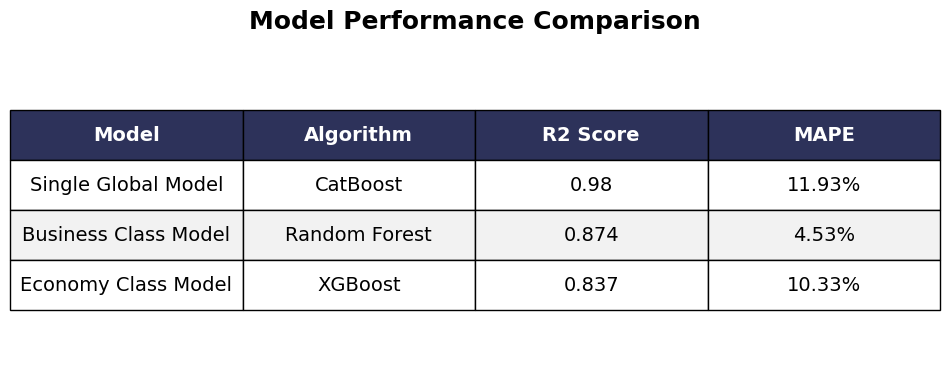

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare your data (removing '(Test)' from columns)
data = {
    "Model": ["Single Global Model", "Business Class Model", "Economy Class Model"],
    "Algorithm": ["CatBoost", "Random Forest", "XGBoost"],
    "R2 Score": [0.980, 0.874, 0.837],
    "MAPE": ["11.93%", "4.53%", "10.33%"]
}

df = pd.DataFrame(data)

# 2. Create the plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')  # Hide axes

# 3. Create the table object
the_table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=["#2d325a"] * len(df.columns) # Dark blue header
)

# 4. Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(1.2, 3)  # Adjust height and width

# Style cells
for (row, col), cell in the_table.get_celld().items():
    # Header styling
    if row == 0:
        cell.get_text().set_color('white')
        cell.get_text().set_weight('bold')
    # Row colors (alternating for readability)
    elif row % 2 == 0:
        cell.set_facecolor('#f2f2f2')
    else:
        cell.set_facecolor('white')

plt.title("Model Performance Comparison", fontsize=18, pad=20, weight='bold')

# 5. Save and Show
plt.savefig('pretty_table.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# ============================================================
# MLR (Multiple Linear Regression) per class
# - SAME train/test split via train_idx/test_idx (fair comparison)
# - Separate model per class (Business / Economy)
# - Drop flight
# - log1p target transform, expm1 back to price for metrics
# - OneHotEncode categoricals + impute missing values
#
# Assumes df is already loaded
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm

SEED = 42
TEST_SIZE = 0.20


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)

    X = add_interactions(X)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

# ------------------------------------------------------------
# SAME split indices (reuse if already created)
# ------------------------------------------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# ------------------------------------------------------------
# Fit MLR per class
# ------------------------------------------------------------
rows = []
models = {}

for cls in tqdm(sorted(df["class"].dropna().unique()), desc="Classes"):
    train_sub = df_train[df_train["class"] == cls].copy()
    test_sub  = df_test[df_test["class"] == cls].copy()

    X_train, y_train, y_train_log = prepare_X_y(train_sub)
    X_test,  y_test,  _           = prepare_X_y(test_sub)

    # align
    X_test = X_test.reindex(columns=X_train.columns)

    pre = build_preprocessor(X_train)

    mlr = LinearRegression(n_jobs=-1)  # plain multiple linear regression
    pipe = Pipeline(steps=[("pre", pre), ("model", mlr)])

    pipe.fit(X_train, y_train_log)

    pred_train = np.clip(np.expm1(pipe.predict(X_train)), 0, None)
    pred_test  = np.clip(np.expm1(pipe.predict(X_test)),  0, None)

    mt = compute_metrics(y_train, pred_train)
    ms = compute_metrics(y_test, pred_test)

    models[cls] = {"pipe": pipe, "features": X_train.columns.tolist()}

    rows.append({
        "class": cls,
        "model": "MLR(LinearRegression)",
        "n_train": len(X_train),
        "n_test": len(X_test),
        "train_RMSE": mt["RMSE"],
        "train_MAE":  mt["MAE"],
        "train_R2":   mt["R2"],
        "test_RMSE":  ms["RMSE"],
        "test_MAE":   ms["MAE"],
        "test_R2":    ms["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("class")
print("\n===== MLR RESULTS (per class | same split) =====")
print(results_df.to_string(index=False))


# ------------------------------------------------------------
# Predict helper for NEW DATA
# ------------------------------------------------------------
def predict_price_mlr_by_class(new_df: pd.DataFrame) -> np.ndarray:
    """
    Predict price for new rows using the correct MLR model based on new_df['class'].
    Returns predictions on ORIGINAL price scale.
    """
    if "class" not in new_df.columns:
        raise ValueError("new_df must contain a 'class' column (Business/Economy).")

    preds = np.full(len(new_df), np.nan, dtype=float)

    for cls in models.keys():
        mask = (new_df["class"] == cls).values
        if not mask.any():
            continue

        sub = new_df.loc[mask].copy()

        if "flight" in sub.columns:
            sub = sub.drop(columns=["flight"])
        if "price" in sub.columns:
            sub = sub.drop(columns=["price"])

        sub = add_interactions(sub)
        sub = sub.reindex(columns=models[cls]["features"])

        log_pred = models[cls]["pipe"].predict(sub)
        preds[mask] = np.clip(np.expm1(log_pred), 0, None)

    return preds


Classes:   0%|          | 0/2 [00:00<?, ?it/s]


===== MLR RESULTS (per class | same split) =====
   class                 model  n_train  n_test  train_RMSE   train_MAE  train_R2   test_RMSE    test_MAE  test_R2
Business MLR(LinearRegression)    24917    6229 8098.521424 5915.855870  0.608432 8007.135992 5905.482255 0.601544
 Economy MLR(LinearRegression)    55083   13771 2487.230144 1650.870318  0.556505 2478.597682 1645.820626 0.557069


In [ ]:
# ============================================================
# FEATURE IMPORTANCE for ALL 3 MODEL TYPES:
#   1) RandomForest (tree importance + permutation importance)
#   2) XGBoost(native booster) (gain importance + permutation importance)
#   3) MLR / LinearRegression (top coefficients + permutation importance)
#
# Works with your per-class workflow.
# Assumes you ALREADY trained models and still have:
#   - Business RF pipeline: rf_pipe  (Pipeline: pre + RandomForest)
#   - Economy XGBoost objects: pre_e (ColumnTransformer), booster (xgb.Booster), best_it (int)
#   - MLR pipelines per class in dict: mlr_models[cls] = {"pipe": Pipeline, "features": [...]}
# Also assumes you still have df_train / df_test and same splits.
#
# If your variable names differ, replace them in the "REQUIRED OBJECTS" section.
# ============================================================

import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from scipy import sparse
import xgboost as xgb

# ----------------------------
# Utility helpers
# ----------------------------
def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X

def get_ohe_feature_names(preprocessor):
    """
    Returns expanded feature names after ColumnTransformer with OneHotEncoder inside.
    Works for the preprocessors we built earlier.
    """
    feat_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            # cols is list of original categorical column names
            ohe_names = list(ohe.get_feature_names_out(cols))
            feat_names.extend(ohe_names)
        else:
            # numeric pipeline: keep original numeric column names
            if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
                feat_names.extend(list(cols))
            else:
                feat_names.append(str(cols))
    return np.array(feat_names, dtype=object)

def top_n_series(s: pd.Series, n=25):
    return s.sort_values(ascending=False).head(n)

def print_top(title, s: pd.Series, n=25):
    print(f"\n=== {title} (top {n}) ===")
    print(top_n_series(s, n).to_string())

# ----------------------------
# REQUIRED OBJECTS (edit if needed)
# ----------------------------
# Business:
#   rf_pipe  -> Pipeline(pre, rf)
#   Xb_train, Xb_test, yb_train, yb_test -> (optional, for permutation on test)
# Economy:
#   pre_e, booster, best_it, Xe_test_df, ye_test -> for permutation on test
# MLR:
#   You should have something like:
#     mlr_models = {"Business": {"pipe": pipe_b, "features": [...]}, "Economy": {...}}
# If you don't have mlr_models dict, you can still run coefficient extraction on any LinearRegression pipeline you have.

# ============================================================
# 1) RANDOM FOREST FEATURE IMPORTANCE (Business)
# ============================================================
def rf_feature_importance(rf_pipe, X_test, y_test, top_n=25, n_repeats=5):
    pre = rf_pipe.named_steps["pre"]
    rf = rf_pipe.named_steps["model"]

    # Built-in impurity importance (fast)
    ohe_names = get_ohe_feature_names(pre)
    imp = pd.Series(rf.feature_importances_, index=ohe_names)
    print_top("RandomForest built-in importance (impurity)", imp, top_n)

    # Permutation importance on TEST (more trustworthy)
    # Note: permutation_importance works on the whole pipeline directly
    perm = permutation_importance(
        rf_pipe, X_test, np.log1p(y_test),  # model is trained on log target
        scoring="neg_mean_absolute_error",
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )
    perm_imp = pd.Series(perm.importances_mean, index=get_ohe_feature_names(pre))
    print_top("RandomForest permutation importance (TEST, MAE)", perm_imp, top_n)

# ============================================================
# 2) XGBOOST FEATURE IMPORTANCE (Economy)
# ============================================================
def xgb_feature_importance(pre_e, booster, best_it, X_test_df, y_test, top_n=25, n_repeats=5):
    # Built-in booster importance: use "gain" (most meaningful)
    score_gain = booster.get_score(importance_type="gain")
    gain = pd.Series(score_gain).sort_values(ascending=False)

    # Map f0,f1,... to actual one-hot feature names
    feat_names = get_ohe_feature_names(pre_e)
    def map_f_to_name(k):
        if k.startswith("f"):
            idx = int(k[1:])
            if 0 <= idx < len(feat_names):
                return feat_names[idx]
        return k

    gain.index = [map_f_to_name(k) for k in gain.index]
    print_top("XGBoost built-in importance (GAIN)", gain, top_n)

    # Permutation importance on TEST (using custom predict wrapper)
    # We create a small wrapper object with predict() so sklearn can permute X_test_df columns.
    class XGBWrapper:
        def __init__(self, pre, booster, best_it):
            self.pre = pre
            self.booster = booster
            self.best_it = int(best_it)

        def predict(self, X):
            Xm = to_csr(self.pre.transform(X))
            d = xgb.DMatrix(Xm)
            # model predicts log(price)
            return self.booster.predict(d, iteration_range=(0, self.best_it + 1))

    xw = XGBWrapper(pre_e, booster, best_it)

    perm = permutation_importance(
        xw, X_test_df, np.log1p(y_test),
        scoring="neg_mean_absolute_error",
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )

    # Here permutation_importance returns importances per ORIGINAL columns (not one-hot).
    perm_imp = pd.Series(perm.importances_mean, index=X_test_df.columns).sort_values(ascending=False)
    print_top("XGBoost permutation importance (TEST, MAE) [original columns]", perm_imp, top_n)

# ============================================================
# 3) MLR FEATURE IMPORTANCE (coefficients + permutation)
# ============================================================
def mlr_feature_importance(mlr_pipe, X_test, y_test, top_n=25, n_repeats=5):
    pre = mlr_pipe.named_steps["pre"]
    lr = mlr_pipe.named_steps["model"]

    # Coefficients are in log-space because training target = log1p(price)
    names = get_ohe_feature_names(pre)
    coefs = pd.Series(np.abs(lr.coef_), index=names).sort_values(ascending=False)
    print_top("MLR coefficient importance (abs(coef), log-space)", coefs, top_n)

    # Permutation importance on TEST
    perm = permutation_importance(
        mlr_pipe, X_test, np.log1p(y_test),
        scoring="neg_mean_absolute_error",
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )
    perm_imp = pd.Series(perm.importances_mean, index=get_ohe_feature_names(pre)).sort_values(ascending=False)
    print_top("MLR permutation importance (TEST, MAE)", perm_imp, top_n)

# ============================================================
# RUN SECTION
# ============================================================
# ---- RandomForest (Business) ----
# You need Xb_test and yb_test from your Business prep step
# rf_feature_importance(rf_pipe, Xb_test, yb_test, top_n=30, n_repeats=5)

# ---- XGBoost (Economy) ----
# You need Xe_test_df and ye_test from your Economy prep step
# xgb_feature_importance(pre_e, booster, best_it, Xe_test_df, ye_test, top_n=30, n_repeats=5)

# ---- MLR (both classes) ----
# Example if you stored them in a dict:
# for cls in ["Business", "Economy"]:
#     mlr_feature_importance(mlr_models[cls]["pipe"], X_test_by_class[cls], y_test_by_class[cls], top_n=30, n_repeats=5)


In [ ]:
rf_feature_importance(rf_pipe, Xb_test, yb_test, top_n=30)


NameError: name 'rf_pipe' is not defined

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# -----------------------------
# Settings (Business RF compromise)
# -----------------------------
SEED = 42
TEST_SIZE = 0.20

BUSINESS_RF = dict(
    n_estimators=800,
    max_depth=40,
    min_samples_leaf=2,
    min_samples_split=8,
    max_features=0.8,
    bootstrap=True,
    max_samples=0.9,
    n_jobs=-1,
    random_state=SEED
)

# -----------------------------
# Helpers
# -----------------------------
def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=TEST_SIZE,
        random_state=SEED,
        shuffle=True,
        stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)
    X = add_interactions(X)
    return X, y, y_log

def build_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def get_ohe_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            names.extend(list(ohe.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return np.array(names, dtype=object)

def rf_feature_importance(rf_pipe, X_test, y_test, top_n=30, n_repeats=5):
    pre = rf_pipe.named_steps["pre"]
    rf = rf_pipe.named_steps["model"]

    # 1) built-in impurity importance
    # This is for the internal features of the model after preprocessing
    ohe_feat_names = get_ohe_feature_names(pre)
    imp = pd.Series(rf.feature_importances_, index=ohe_feat_names).sort_values(ascending=False)
    print(f"\n=== RandomForest built-in importance (top {top_n}) ===")
    print(imp.head(top_n).to_string())

    # 2) permutation importance on TEST (on log scale because model predicts log1p(price))
    # As per sklearn documentation, when a Pipeline with a preprocessor is passed,
    # permutation_importance computes importance on the ORIGINAL features of X_test.
    perm = permutation_importance(
        rf_pipe,
        X_test,
        np.log1p(y_test),
        scoring="neg_mean_absolute_error",
        n_repeats=n_repeats,
        random_state=SEED,
        n_jobs=-1
    )
    # The importances_mean here will correspond to the ORIGINAL columns of X_test
    perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
    print(f"\n=== RandomForest permutation importance on TEST (top {top_n}) ===")
    print(perm_imp.head(top_n).to_string())

# -----------------------------
# (Re)create split indices if missing
# -----------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -----------------------------
# Train Business RF pipeline (defines rf_pipe, Xb_test, yb_test)
# -----------------------------
train_b = df_train[df_train["class"] == "Business"].copy()
test_b  = df_test[df_test["class"] == "Business"].copy()

Xb_train, yb_train, yb_train_log = prepare_X_y(train_b)
Xb_test,  yb_test,  _            = prepare_X_y(test_b)

# align columns
Xb_test = Xb_test.reindex(columns=Xb_train.columns)

pre_b = build_preprocessor(Xb_train)

rf_pipe = Pipeline([
    ("pre", pre_b),
    ("model", RandomForestRegressor(**BUSINESS_RF))
])

rf_pipe.fit(Xb_train, yb_train_log)

# -----------------------------
# Now this will work (no NameError)
# -----------------------------
rf_feature_importance(rf_pipe, Xb_test, yb_test, top_n=30, n_repeats=5)


=== RandomForest built-in importance (top 30) ===
duration                                   0.559481
stops_zero                                 0.078847
days_left                                  0.040374
airline_Air_India                          0.036283
airline_Vistara                            0.032987
stops_one                                  0.021341
source_city_Delhi                          0.012186
destination_city_Delhi                     0.011027
arrival_time_Evening                       0.009880
source_city_Kolkata                        0.008510
destination_city_Kolkata                   0.007379
arrival_time_Afternoon                     0.007262
arrival_time_Night                         0.007134
departure_time_Evening                     0.006860
destination_city_Hyderabad                 0.006579
arrival_time_Early_Morning                 0.005545
departure_time_Afternoon                   0.005311
departure_time_Morning                     0.005223
destination_c

In [ ]:
# ============================================================
# XGBoost (Economy) FEATURE IMPORTANCE
# 1) Built-in importance (GAIN) from the booster
# 2) Permutation importance on TEST (more trustworthy)
#
# Assumes you ALREADY trained Economy XGBoost and still have:
#   - pre_e        : ColumnTransformer used for Economy (fit)
#   - booster      : xgb.Booster
#   - best_it      : int (best_iteration)
#   - Xe_test_df   : Economy test DataFrame (original feature columns, after your feature engineering)
#   - ye_test      : Economy test prices on ORIGINAL scale
#
# If any of these names differ in your notebook, replace accordingly.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from scipy import sparse
import xgboost as xgb

SEED = 42

def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X

def get_ohe_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            names.extend(list(ohe.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return np.array(names, dtype=object)

def xgb_gain_importance(pre_e, booster, top_n=30):
    """
    Built-in XGBoost importance using GAIN, mapped to readable feature names.
    """
    feat_names = get_ohe_feature_names(pre_e)

    gain_dict = booster.get_score(importance_type="gain")
    if not gain_dict:
        print("No gain importance found. (Model might not have splits or importance unavailable.)")
        return

    gain = pd.Series(gain_dict).sort_values(ascending=False)

    def map_f_to_name(k):
        # keys look like 'f0','f1',...
        if k.startswith("f"):
            i = int(k[1:])
            if 0 <= i < len(feat_names):
                return feat_names[i]
        return k

    gain.index = [map_f_to_name(k) for k in gain.index]

    print(f"\n=== XGBoost built-in feature importance (GAIN) top {top_n} ===")
    print(gain.head(top_n).to_string())

class XGBWrapper:
    """
    Minimal wrapper so sklearn.permutation_importance can call .predict(X_df)
    and we internally apply preprocessor + xgb predict.
    """
    def __init__(self, pre, booster, best_it):
        self.pre = pre
        self.booster = booster
        self.best_it = int(best_it)

    def predict(self, X_df):
        Xm = to_csr(self.pre.transform(X_df))
        d = xgb.DMatrix(Xm)
        # model outputs log1p(price)
        return self.booster.predict(d, iteration_range=(0, self.best_it + 1))

def xgb_permutation_importance(pre_e, booster, best_it, Xe_test_df, ye_test, top_n=30, n_repeats=5):
    """
    Permutation importance on TEST, measured on log1p(price) target,
    returned for ORIGINAL (pre-onehot) columns (easier to interpret).
    """
    model = XGBWrapper(pre_e, booster, best_it)

    perm = permutation_importance(
        model,
        Xe_test_df,
        np.log1p(ye_test),  # log target because model predicts log1p(price)
        scoring="neg_mean_absolute_error",
        n_repeats=n_repeats,
        random_state=SEED,
        n_jobs=-1
    )

    perm_imp = pd.Series(perm.importances_mean, index=Xe_test_df.columns).sort_values(ascending=False)
    print(f"\n=== XGBoost permutation importance on TEST (MAE) top {top_n} ===")
    print(perm_imp.head(top_n).to_string())

# ----------------------------
# RUN
# ----------------------------
# Built-in (GAIN) importance (one-hot expanded)
xgb_gain_importance(pre_e, booster, top_n=30)

# Permutation importance (original columns)
xgb_permutation_importance(pre_e, booster, best_it, Xe_test_df, ye_test, top_n=30, n_repeats=5)


NameError: name 'pre_e' is not defined

In [ ]:
# ============================================================
# FIX for NameError: pre_e not defined
# -> Rebuild Economy XGBoost (native early stopping) + Feature Importance
#
# Outputs:
# 1) XGBoost built-in feature importance (GAIN) [one-hot expanded]
# 2) Permutation importance on TEST (MAE) [original columns]
#
# Assumes df is already loaded.
# Uses SAME train/test split indices if train_idx/test_idx exist; otherwise creates them.
# Drops flight, uses log1p target, expm1 back only for metrics (importance uses log-space).
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

import xgboost as xgb
from scipy import sparse

SEED = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15

# ---- XGBoost params (as-is style) ----
XGB_PARAMS = {
    "eta": 0.05,
    "max_depth": 10,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "gamma": 0.0,
}
XGB_TREE_METHOD = "hist"
XGB_NUM_BOOST_ROUND = 20000
XGB_EARLY_STOPPING_ROUNDS = 200

# -----------------------------
# Helpers
# -----------------------------
def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X

def make_split_indices(df):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=df["class"]
    )
    return train_idx, test_idx

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if "source_city" in X.columns and "destination_city" in X.columns:
        X["route"] = X["source_city"].astype(str) + "->" + X["destination_city"].astype(str)
    if "airline" in X.columns and "route" in X.columns:
        X["route_airline"] = X["airline"].astype(str) + "_" + X["route"].astype(str)
    return X

def prepare_X_y(df_sub: pd.DataFrame):
    df_sub = df_sub.copy()
    df_sub["price"] = pd.to_numeric(df_sub["price"], errors="coerce")
    df_sub = df_sub.dropna(subset=["price"])

    y = df_sub["price"].astype(float).values
    y_log = np.log1p(y)

    drop_cols = [c for c in ["price", "class", "flight"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_cols)
    X = add_interactions(X)
    return X, y, y_log

def get_feature_lists(X: pd.DataFrame):
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols

def make_onehot_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )

def get_ohe_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            names.extend(list(ohe.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return np.array(names, dtype=object)

# -----------------------------
# 1) Same split indices
# -----------------------------
if "train_idx" not in globals() or "test_idx" not in globals():
    train_idx, test_idx = make_split_indices(df)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# -----------------------------
# 2) Build Economy XGBoost (defines pre_e, booster, best_it, Xe_test_df, ye_test)
# -----------------------------
train_e = df_train[df_train["class"] == "Economy"].copy()
test_e  = df_test[df_test["class"] == "Economy"].copy()

Xe_full, ye_full, ye_full_log = prepare_X_y(train_e)
Xe_test_df, ye_test, _        = prepare_X_y(test_e)

# align (important)
Xe_test_df = Xe_test_df.reindex(columns=Xe_full.columns)

# internal train/val for early stopping
Xe_tr_df, Xe_val_df, ye_tr, ye_val, ye_tr_log, ye_val_log = train_test_split(
    Xe_full, ye_full, ye_full_log,
    test_size=VAL_SIZE, random_state=SEED, shuffle=True
)

num_cols_e, cat_cols_e = get_feature_lists(Xe_tr_df)
pre_e = make_onehot_preprocessor(num_cols_e, cat_cols_e)

Xe_tr  = to_csr(pre_e.fit_transform(Xe_tr_df))
Xe_val = to_csr(pre_e.transform(Xe_val_df))
Xe_full_mat = to_csr(pre_e.transform(Xe_full))
Xe_test_mat = to_csr(pre_e.transform(Xe_test_df))

feat_names = list(get_ohe_feature_names(pre_e))

dtrain = xgb.DMatrix(Xe_tr, label=ye_tr_log, feature_names=feat_names)
dval   = xgb.DMatrix(Xe_val, label=ye_val_log, feature_names=feat_names)
dfull  = xgb.DMatrix(Xe_full_mat, label=ye_full_log, feature_names=feat_names)
dtest  = xgb.DMatrix(Xe_test_mat, feature_names=feat_names)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": XGB_TREE_METHOD,
    "seed": SEED,
    **XGB_PARAMS
}

print("\nTraining Economy -> XGBoost(native) with early stopping ...")
booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=XGB_NUM_BOOST_ROUND,
    evals=[(dval, "val")],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=200
)

best_it = int(booster.best_iteration)
print(f"\nBest iteration (Economy XGB): {best_it}")

# -----------------------------
# 3) Feature importance (GAIN) - one-hot expanded
# -----------------------------
gain = booster.get_score(importance_type="gain")
gain_s = pd.Series(gain).sort_values(ascending=False)

top_n = 30
print(f"\n=== XGBoost built-in feature importance (GAIN) top {top_n} ===")
print(gain_s.head(top_n).to_string())

# -----------------------------
# 4) Permutation importance on TEST (original columns)
#    Note: This permutes original DataFrame columns (NOT one-hot columns).
#    Target is log1p(price) because model predicts log1p(price).
# -----------------------------
class XGBWrapper:
    def __init__(self, pre, booster, best_it, feat_names):
        self.pre = pre
        self.booster = booster
        self.best_it = int(best_it)
        self.feat_names = feat_names

    def predict(self, X_df):
        Xm = to_csr(self.pre.transform(X_df))
        d = xgb.DMatrix(Xm, feature_names=self.feat_names)
        return self.booster.predict(d, iteration_range=(0, self.best_it + 1))

xw = XGBWrapper(pre_e, booster, best_it, feat_names)

perm = permutation_importance(
    xw,
    Xe_test_df,
    np.log1p(ye_test),
    scoring="neg_mean_absolute_error",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

perm_s = pd.Series(perm.importances_mean, index=Xe_test_df.columns).sort_values(ascending=False)

print(f"\n=== XGBoost permutation importance on TEST (MAE) top {top_n} ===")
print(perm_s.head(top_n).to_string())



Training Economy -> XGBoost(native) with early stopping ...
[0]	val-rmse:0.50349
[200]	val-rmse:0.19345
[400]	val-rmse:0.18339
[600]	val-rmse:0.17689
[800]	val-rmse:0.17348
[1000]	val-rmse:0.17113
[1200]	val-rmse:0.16962
[1400]	val-rmse:0.16868
[1600]	val-rmse:0.16774
[1800]	val-rmse:0.16732
[2000]	val-rmse:0.16685
[2200]	val-rmse:0.16661
[2400]	val-rmse:0.16631
[2600]	val-rmse:0.16618
[2800]	val-rmse:0.16606
[2994]	val-rmse:0.16614

Best iteration (Economy XGB): 2794

=== XGBoost built-in feature importance (GAIN) top 30 ===
airline_AirAsia                                4.347416
airline_Indigo                                 1.266701
source_city_Kolkata                            1.173146
route_Mumbai->Hyderabad                        1.170618
route_Delhi->Bangalore                         0.940783
airline_Vistara                                0.885816
route_Chennai->Hyderabad                       0.841112
route_Bangalore->Delhi                         0.834327
route_Hyderabad->Mu

InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <__main__.XGBWrapper object at 0x7a0f478996a0> instead.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
from scipy import sparse

SEED = 42

def to_csr(X):
    return X.tocsr() if sparse.issparse(X) else X

# ---- estimator wrapper that sklearn accepts (has fit + predict) ----
class XGBSklearnWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, pre, booster, best_it, feature_names):
        self.pre = pre
        self.booster = booster
        self.best_it = int(best_it)
        self.feature_names = list(feature_names)

    def fit(self, X, y=None):
        # no-op: model is already trained (booster)
        return self

    def predict(self, X):
        Xm = to_csr(self.pre.transform(X))
        d = xgb.DMatrix(Xm, feature_names=self.feature_names)
        return self.booster.predict(d, iteration_range=(0, self.best_it + 1))

# ---- make sure these exist from your previous training cell ----
# pre_e, booster, best_it, feat_names, Xe_test_df, ye_test

xw = XGBSklearnWrapper(pre_e, booster, best_it, feat_names)

perm = permutation_importance(
    estimator=xw,
    X=Xe_test_df,
    y=np.log1p(ye_test),                 # because model predicts log1p(price)
    scoring="neg_mean_absolute_error",   # permutation effect measured on MAE
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

perm_s = pd.Series(perm.importances_mean, index=Xe_test_df.columns).sort_values(ascending=False)

top_n = 30
print(f"\n=== XGBoost permutation importance on TEST (MAE) top {top_n} ===")
print(perm_s.head(top_n).to_string())



=== XGBoost permutation importance on TEST (MAE) top 30 ===
days_left           0.260703
duration            0.137041
airline             0.130266
route_airline       0.050233
route               0.036153
source_city         0.035046
departure_time      0.023513
destination_city    0.023429
arrival_time        0.022974
stops               0.022326


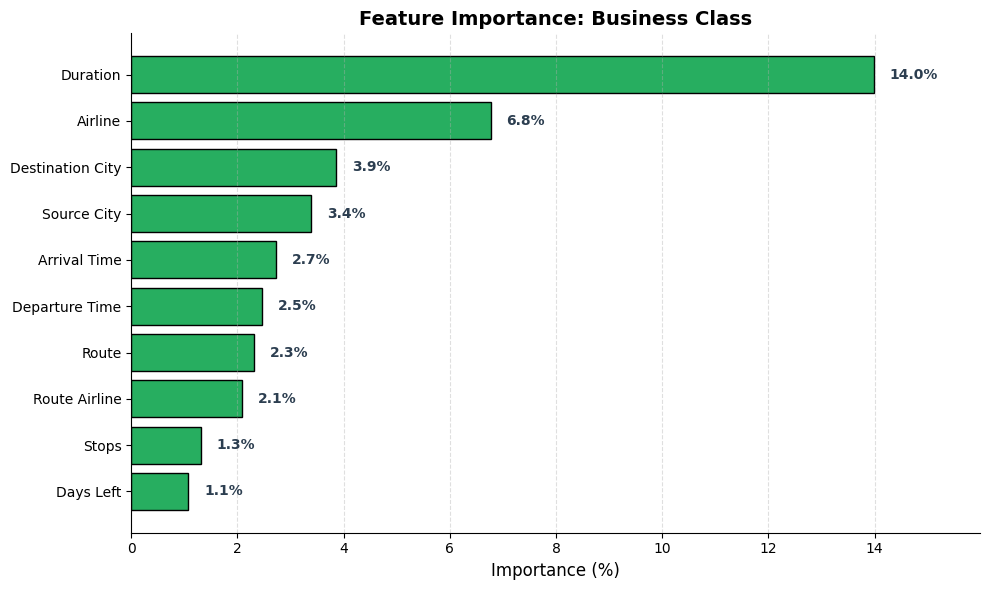

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data from your results
data = {
    'Feature': [
        'Duration', 'Airline', 'Destination City', 'Source City',
        'Arrival Time', 'Departure Time', 'Route', 'Route Airline',
        'Stops', 'Days Left'
    ],
    'Importance': [
        0.139849, 0.067679, 0.038521, 0.033809, 0.027304,
        0.024550, 0.023076, 0.020856, 0.013072, 0.010720
    ]
}

df = pd.DataFrame(data)

# 2. Convert Importance to Percentage
df['Importance_Pct'] = df['Importance'] * 100
df = df.sort_values(by='Importance_Pct', ascending=True)

# 3. Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Feature'], df['Importance_Pct'], color='#27AE60', edgecolor='black')

# 4. Add percentage labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontweight='bold', color='#2c3e50')

# 5. Styling
plt.xlabel('Importance (%)', fontsize=12)
plt.title('Feature Importance: Business Class', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Modern cleanup
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Increase the x-axis limit slightly to make room for the labels
plt.xlim(0, max(df['Importance_Pct']) + 2)

plt.tight_layout()
plt.show()

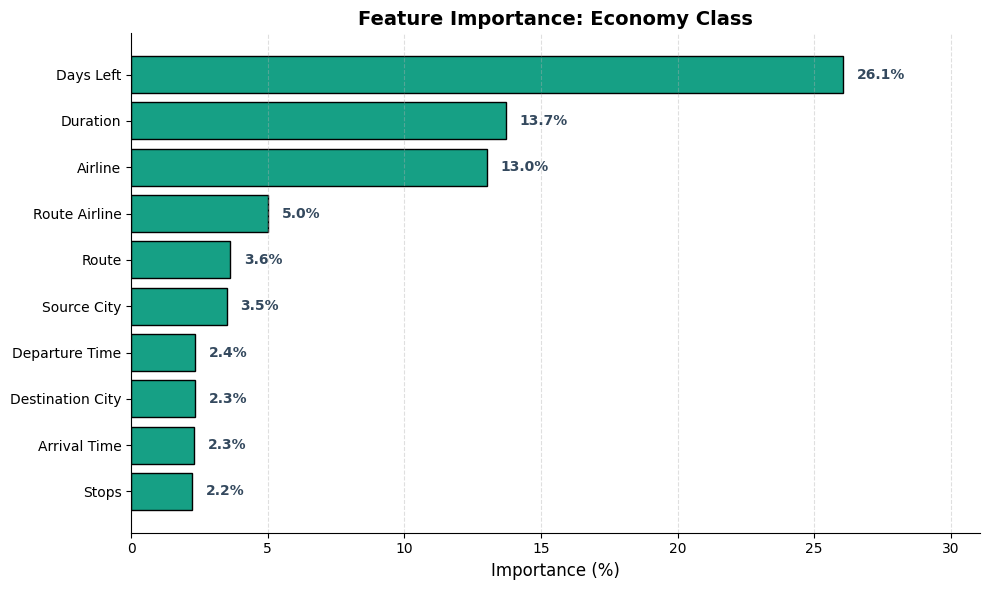

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data for Economy Class (Top 10)
data_economy = {
    'Feature': [
        'Days Left', 'Duration', 'Airline', 'Route Airline',
        'Route', 'Source City', 'Departure Time',
        'Destination City', 'Arrival Time', 'Stops'
    ],
    'Importance': [
        0.260703, 0.137041, 0.130266, 0.050233,
        0.036153, 0.035046, 0.023513, 0.023429,
        0.022974, 0.022326
    ]
}

# 2. Create DataFrame and convert Importance to Percentage
df_econ = pd.DataFrame(data_economy)
df_econ['Importance_Pct'] = df_econ['Importance'] * 100
df_econ = df_econ.sort_values(by='Importance_Pct', ascending=True)

# 3. Create the plot with Sea Green color
plt.figure(figsize=(10, 6))
bars = plt.barh(df_econ['Feature'], df_econ['Importance_Pct'], color='#16a085', edgecolor='black')

# 4. Add percentage labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontweight='bold', color='#34495e')

# 5. Styling and labels
plt.xlabel('Importance (%)', fontsize=12)
plt.title('Feature Importance: Economy Class', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Modern cleanup
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add extra space on the right for the percentage labels
plt.xlim(0, max(df_econ['Importance_Pct']) + 5)

plt.tight_layout()
plt.show()